In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

In [2]:
cwd = os.getcwd()
images_path = os.path.join(os.path.dirname(cwd), "segment_SHAP", "evaluation", "images")

In [3]:
### Apply function to values in nested dictionary

def apply_recursive(obj, func):
    if isinstance(obj, dict):  # if dict, apply to each key
        return {k: apply_recursive(v, func) for k, v in obj.items()}
    elif isinstance(obj, list):  # if list, apply to each element
        return [apply_recursive(elem, func) for elem in obj]
    else:
        return func(obj)

def flatten_dict(nested_dict):
    res = {}
    if isinstance(nested_dict, dict):
        for k in nested_dict:
            flattened_dict = flatten_dict(nested_dict[k])
            for key, val in flattened_dict.items():
                key = list(key)
                key.insert(0, k)
                res[tuple(key)] = val
    else:
        res[()] = nested_dict
    return res


def nested_dict_to_df(values_dict, level=-1):
    #print(values_dict)
    flat_dict = flatten_dict(values_dict)
    #print(flat_dict)
    df = pd.DataFrame.from_dict(flat_dict, orient="index")
    df.index = pd.MultiIndex.from_tuples(df.index)
    # df = df.unstack(level=level)
    # df.columns = df.columns.map("{0[1]}".format)
    return df

def load_to_multi_index(path):
    results_dict = np.load(path, allow_pickle=True) #.item()
    fixed_results_dict = results_dict # apply_recursive(results_dict, lambda df: df.iloc[0].to_dict())
    df = nested_dict_to_df(fixed_results_dict)
    df.index.names = ['Dataset','Segmentation', 'ML model', 'Background', 'Normalization', 'Perturb', 'Metric']
    df.columns = ['Result']
    return df

# debug
# results_dict['UWAVE']['infogain']['resNet']['average']['normalized']['normal_distribution']


def load_from_folder(path):
    filenames = os.listdir(path) # [filename for filename in os.listdir(mypath) if os.path.isfile(os.path.join(mypath, filename))] # excludes floders
    df_list = []
    for filename in filenames:
        filepath = os.path.join(path, filename)
        df = load_to_multi_index(path=filepath)
        df_list.append(df)
    merged_df = pd.concat(df_list)
    return merged_df


In [4]:
cwd = os.getcwd()
path = os.path.join(os.path.dirname(cwd), "segment_SHAP", "evaluation", "results", "interprettime_results")
df_first = load_from_folder(path=path)
df_first.head()

Result
Dataset Segmentation ML model   Background Normalization Perturb             Metric             
EOG     binSeg       miniRocket average    normalized    normal_distribution AUCSE_top  0.496721
                                                                             F_score    0.250907
                                                         global_mean         AUCSE_top  0.534784
                                                                             F_score    0.256512
                                                         local_mean          AUCSE_top  0.544627

In [5]:
path = os.path.join(os.path.dirname(cwd), "segment_SHAP", "evaluation", "results", "aucdiff_results")
filenames = os.listdir(path) # [filename for filename in os.listdir(mypath) if os.path.isfile(os.path.join(mypath, filename))] # excludes floders
df_list = []
for filename in filenames:
    filepath = os.path.join(path, filename)
    df_0 = pd.read_csv(filepath, index_col=0)
    df_list.append(df_0)
merged_df = pd.concat(df_list)
df_second = merged_df.set_index(['Dataset','Segmentation', 'ML model', 'Background', 'Normalization', 'Perturb', 'Metric'])
df_second.head()

Result
Dataset Segmentation ML model   Background Normalization Perturb   Metric                  
EOG     clasp        miniRocket average    default       insertion AUC_difference  0.080664
                                                         deletion  AUC_difference  0.061430
                                                         insertion AUC_difference  0.037608
                                                         deletion  AUC_difference  0.032819
                                           normalized    insertion AUC_difference  0.079614

In [30]:
df = pd.concat([df_first, df_second]).reset_index()

# Translation
translation_dict = {"AUCSE_top": "AUCSE", "F_score": "F-score", "AUC_difference": "AUCD"}
df['Metric'] = df['Metric'].replace(translation_dict)

translation_dict = {"KeplerLightCurves": "KLC", "gunpoint": "GNP"}
df['Dataset'] = df['Dataset'].replace(translation_dict)

# QUICKFIX for separating mean and std for AUCD (Temporary)

columns_wo_result = list(df.columns)
columns_wo_result.remove("Result")
all_duplicate = df.duplicated(subset=columns_wo_result)
mean_idxs = df.duplicated(subset=columns_wo_result, keep='last')
std_idxs = df.duplicated(subset=columns_wo_result, keep='first')
df.loc[mean_idxs, "Perturb"] += "_mean"
df.loc[std_idxs, "Perturb"] += "_std"

In [31]:
df

,Dataset,Segmentation,ML model,Background,Normalization,Perturb,Metric,Result
0,EOG,binSeg,miniRocket,average,normalized,normal_distribution,AUCSE,0.496721
1,EOG,binSeg,miniRocket,average,normalized,normal_distribution,F-score,0.250907
2,EOG,binSeg,miniRocket,average,normalized,global_mean,AUCSE,0.534784
3,EOG,binSeg,miniRocket,average,normalized,global_mean,F-score,0.256512
4,EOG,binSeg,miniRocket,average,normalized,local_mean,AUCSE,0.544627
...,...,...,...,...,...,...,...,...
8635,UWAVE,bottomUp,resNet,zero,default,deletion_std,AUCD,0.130497
8636,UWAVE,bottomUp,resNet,zero,normalized,insertion_mean,AUCD,0.338062
8637,UWAVE,bottomUp,resNet,zero,normalized,deletion_mean,AUCD,0.136664
8638,UWAVE,bottomUp,resNet,zero,normalized,insertion_std,AUCD,0.174196


## Masking

In [9]:
mask = (df["Metric"] == 'F-score') & (df["Result"] > 1)
df.loc[mask]

,Dataset,Segmentation,ML model,Background,Normalization,Perturb,Metric,Result


In [10]:
mask = (df["Metric"] == 'F-score') & (df["Result"] < 0)
df.loc[mask].head()

,Dataset,Segmentation,ML model,Background,Normalization,Perturb,Metric,Result
1153,gunpoint,bottomUp,miniRocket,average,normalized,normal_distribution,F-score,-0.077633
1159,gunpoint,bottomUp,miniRocket,average,normalized,global_gaussian,F-score,-0.077656
1161,gunpoint,bottomUp,miniRocket,average,default,normal_distribution,F-score,-0.072358
1163,gunpoint,bottomUp,miniRocket,average,default,global_mean,F-score,-0.001675
1167,gunpoint,bottomUp,miniRocket,average,default,global_gaussian,F-score,-0.072388


In [12]:
mask = (df["Metric"] == "AUCSE") & (df["Result"] < 0)
df.loc[mask].head()

,Dataset,Segmentation,ML model,Background,Normalization,Perturb,Metric,Result
1152,gunpoint,bottomUp,miniRocket,average,normalized,normal_distribution,AUCSE,-0.188875
1154,gunpoint,bottomUp,miniRocket,average,normalized,global_mean,AUCSE,-0.015736
1158,gunpoint,bottomUp,miniRocket,average,normalized,global_gaussian,AUCSE,-0.189138
1160,gunpoint,bottomUp,miniRocket,average,default,normal_distribution,AUCSE,-0.190807
1162,gunpoint,bottomUp,miniRocket,average,default,global_mean,AUCSE,-0.019952


In [13]:
mask = (df["Metric"] == 'AUCD') & (df["Result"] < 0)
df.loc[mask].head()

,Dataset,Segmentation,ML model,Background,Normalization,Perturb,Metric,Result


# Data Analysis

## Correlation matrix for InterpretTime Perturb methods

In [16]:
mask = (df["Metric"]=="AUCSE")
df2 = df.loc[mask] # , ['Perturb', "Result"]
df2 = df2.pivot(index = ['Dataset', 'Segmentation', 'ML model', 'Background', 'Normalization', 'Metric'], columns='Perturb', values="Result")
corr = df2.corr()
coef_det = corr ** 2
coef_det.style.background_gradient(cmap='coolwarm', vmin=0, vmax=1).format(precision=2) # 'coolwarm', 'RdBu_r', 'BrBG_r', 'PuOr_r'

Perturb,global_gaussian,global_mean,local_mean,normal_distribution
Perturb,,,,
global_gaussian,1.00,0.79,0.65,0.87
global_mean,0.79,1.00,0.66,0.64
local_mean,0.65,0.66,1.00,0.48
normal_distribution,0.87,0.64,0.48,1.00


In [17]:
mask = (df["Metric"]=='F-score')
df2 = df.loc[mask] # , ['Perturb', "Result"]
df2 = df2.pivot(index = ['Dataset', 'Segmentation', 'ML model', 'Background', 'Normalization', 'Metric'], columns='Perturb', values="Result")
corr = df2.corr()
coef_det = corr ** 2
coef_det.style.background_gradient(cmap='coolwarm', vmin=0, vmax=1).format(precision=2) # 'coolwarm', 'RdBu_r', 'BrBG_r', 'PuOr_r'

Perturb,global_gaussian,global_mean,local_mean,normal_distribution
Perturb,,,,
global_gaussian,1.00,0.81,0.69,0.92
global_mean,0.81,1.00,0.77,0.86
local_mean,0.69,0.77,1.00,0.68
normal_distribution,0.92,0.86,0.68,1.00


In [18]:
# df2 = df.unstack(["Metric"])
# df2.columns = df2.columns.droplevel(0)
# corr = df2.corr()
# coef_det = corr ** 2
# coef_det.style.background_gradient(cmap='coolwarm', vmin=0, vmax=1).format(precision=2) # 'coolwarm', 'RdBu_r', 'BrBG_r', 'PuOr_r'

In [14]:
df["Perturb"].unique()

array(['normal_distribution', 'global_mean', 'local_mean',
       'global_gaussian', 'insertion_mean', 'deletion_mean',
       'insertion_std', 'deletion_std'], dtype=object)

In [15]:
values_to_delete = ['insertion_std', 'deletion_std']
values_to_aggregate = ['normal_distribution', 'global_mean', 'local_mean', 'global_gaussian']
filtered_df = df[~df['Perturb'].isin(values_to_delete)]
to_aggregate = filtered_df[filtered_df['Perturb'].isin(values_to_aggregate)]
to_keep = filtered_df[~filtered_df['Perturb'].isin(values_to_aggregate)]
group_cols = [col for col in filtered_df.columns if col not in ['Perturb', 'Result']]
aggregated = to_aggregate.groupby(group_cols, as_index=False)['Result'].mean()
aggregated['Perturb'] = 'mean'
pivoted = to_keep.pivot_table(index=to_keep.columns.difference(['Perturb', 'Result']).tolist(), columns='Perturb', values='Result').reset_index()
pivoted['Result'] = pivoted['insertion_mean'] - pivoted['deletion_mean']
pivoted['Perturb'] = 'mean'
pivoted = pivoted.drop(['deletion_mean', 'insertion_mean'], axis=1)
final_df = pd.concat([pivoted, aggregated])
pivoted = final_df.pivot(index=final_df.columns.difference(['Metric', 'Result']).tolist(), columns='Metric', values='Result')
corr_matrix = pivoted.corr()
print("\nCorr Matrix:", corr_matrix)



Corr Matrix: Metric       AUCD     AUCSE   F-score
Metric                               
AUCD     1.000000  0.621939  0.517965
AUCSE    0.621939  1.000000  0.911627
F-score  0.517965  0.911627  1.000000


In [17]:
to_remove = (df["Segmentation"]=='windowBased')
df = df[~to_remove]

values_to_delete = ['insertion_std', 'deletion_std']
values_to_aggregate = ['deletion_mean', 'insertion_mean']
filtered_df = df[~df['Perturb'].isin(values_to_delete)]
to_aggregate = filtered_df[filtered_df['Perturb'].isin(values_to_aggregate)]
to_keep = filtered_df[~filtered_df['Perturb'].isin(values_to_aggregate)]

pivoted = to_aggregate.pivot_table(index=to_aggregate.columns.difference(['Perturb', 'Result']).tolist(), columns='Perturb', values='Result').reset_index()
pivoted['mean'] = pivoted['insertion_mean'] - pivoted['deletion_mean']
pivoted['Perturb'] = 'mean'
pivoted = pivoted.drop(['deletion_mean', 'insertion_mean'], axis=1)

cat_cols = to_aggregate.columns.difference(['Perturb', 'Result'])

melted = pivoted.melt(
        id_vars=cat_cols,
        value_vars=['mean'],
        var_name='Perturb',
        value_name='Result'
    ).dropna(subset=['Result'])

final_df = pd.concat([to_keep, melted])#.reset_index()

df = final_df


### AUCSE_top
#### local_mean vs global_mean

In [23]:
df.columns

Index(['Dataset', 'Segmentation', 'ML model', 'Background', 'Normalization',
       'Perturb', 'Metric', 'Result'],
      dtype='object')

In [24]:
columns_wo_result = list(df.columns)
columns_wo_result.remove("Result")

In [25]:
columns_wo_result

['Dataset',
 'Segmentation',
 'ML model',
 'Background',
 'Normalization',
 'Perturb',
 'Metric']

# One factor aggregate results - Unnormalized

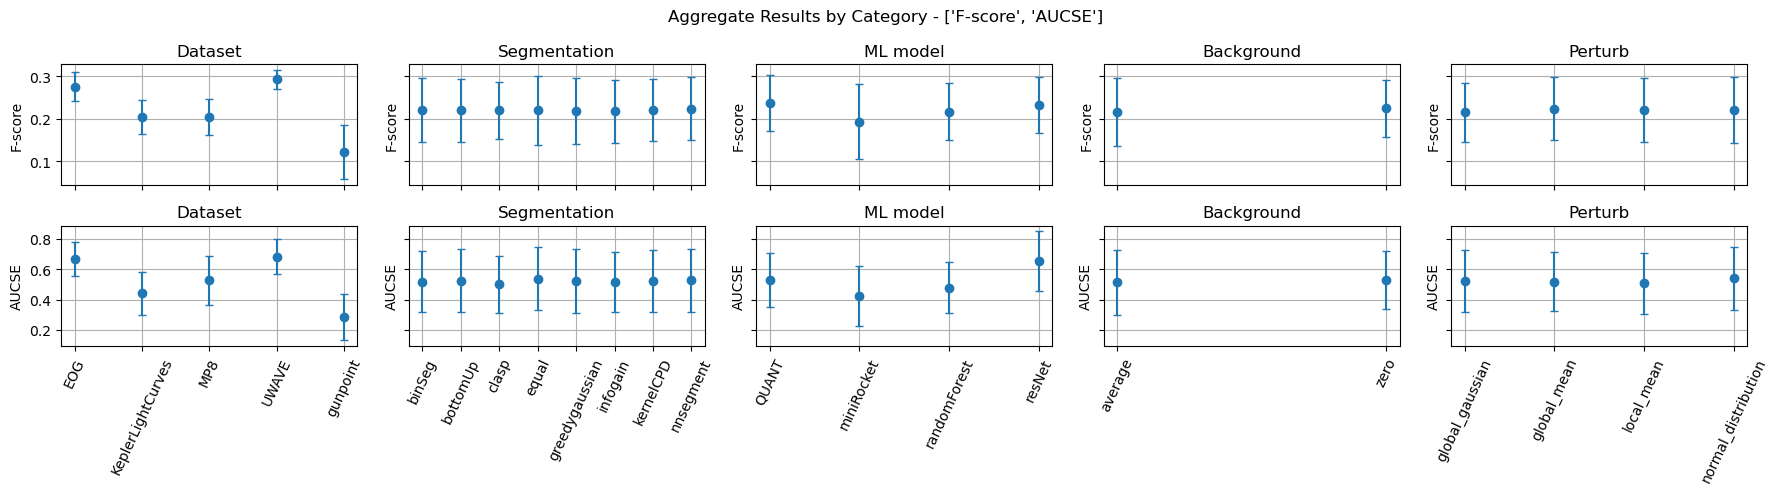

In [19]:
active_columns = columns_wo_result.copy()
active_columns.remove("Metric")
active_columns.remove("Normalization")
metric_names = ['F-score', "AUCSE"]

fig, ax = plt.subplots(len(metric_names), len(active_columns), figsize = (18,5), sharex="col", sharey="row")

for j, metric_name in enumerate(metric_names):

    mask = (df["Metric"]==metric_name) & (df["Normalization"]=="default")
    df2 = df.loc[mask] # , ['Perturb', "Result"]
    #ax[j].set_title(metric_name)

    for i, column_name in enumerate(active_columns):
        df3 = df2.groupby([column_name]).agg({'Result': ["mean", "std"]})
        df3_mean = df3[("Result", "mean")]
        df3_std = df3[("Result", "std")]
        
        ax[j, i].errorbar(df3.index, df3_mean.values, df3_std, linestyle='None', marker='o', capsize=3)
        ax[j, i].grid()
        ax[j, i].tick_params("x", rotation=65)
        ax[j, i].set_title(column_name)
        ax[j, i].set_ylabel(metric_name)

for axis, metric_name in zip(ax[:, 0], metric_names):
    axis.set_ylabel(metric_name)

fig.suptitle("Aggregate Results by Category - " + str(metric_names))
fig.tight_layout()

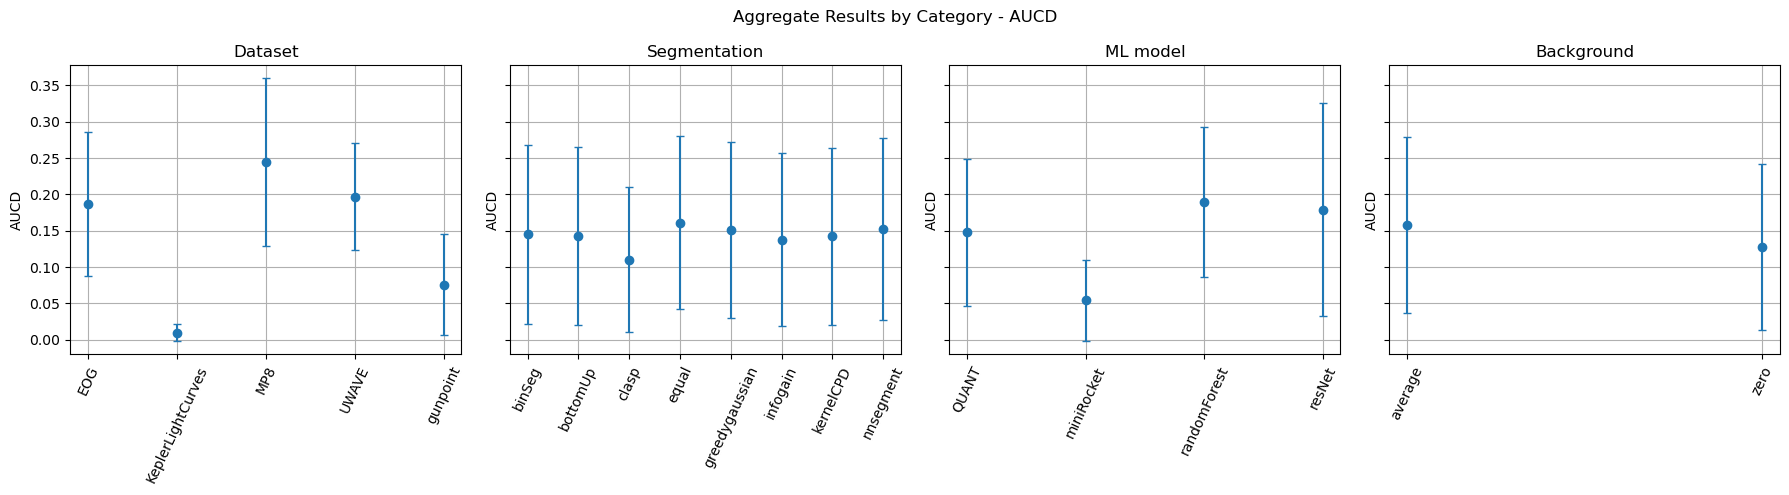

In [20]:
active_columns = columns_wo_result.copy()
active_columns.remove("Metric")
active_columns.remove("Perturb")
active_columns.remove("Normalization")
metric_names = ["AUCD"]
perturb_name = "mean"

fig, ax = plt.subplots(len(metric_names), len(active_columns), figsize = (18, 5), sharex="col", sharey=True, squeeze=False)

for j, metric_name in enumerate(metric_names):

    mask = (df["Metric"]==metric_name) & (df["Perturb"]==perturb_name) & (df["Normalization"]=="default")
    df2 = df.loc[mask]

    for i, column_name in enumerate(active_columns):
        df3 = df2.groupby([column_name]).agg({'Result': ["mean", "std"]})
        df3.columns = df3.columns.get_level_values(1)
        df3_mean = df3["mean"]
        df3_std = df3["std"]
        
        ax[j, i].errorbar(df3.index, df3_mean.values, df3_std, linestyle='None', marker='o', capsize=3)
        ax[j, i].grid()
        ax[j, i].tick_params("x", rotation=65)
        ax[j, i].set_title(column_name)
        ax[j, i].set_ylabel(metric_name)


    ax[j, 0].set_ylabel(metric_name)

fig.suptitle("Aggregate Results by Category - " + metric_name)
fig.tight_layout()

# Two factor aggregate results - Unnormalized

In [21]:
from itertools import combinations

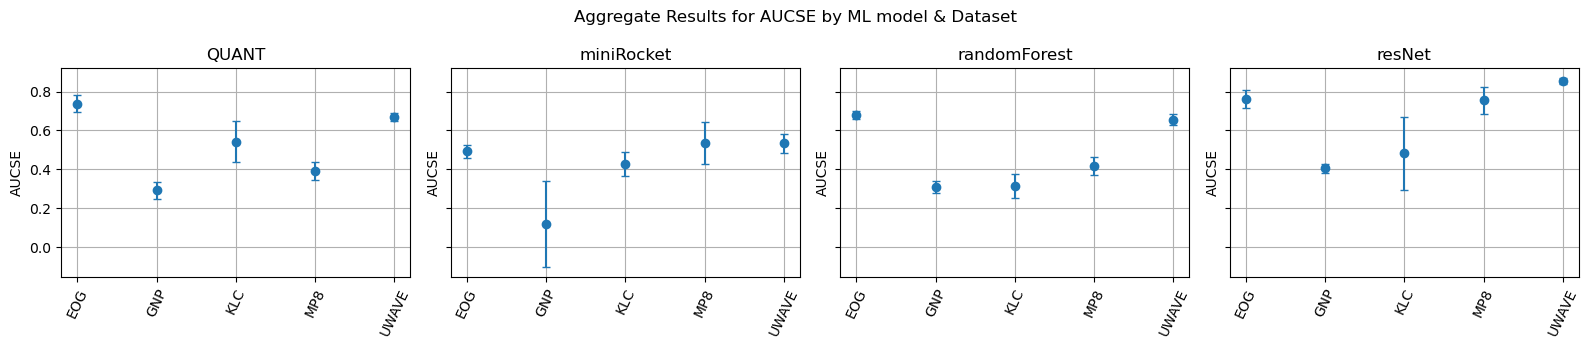

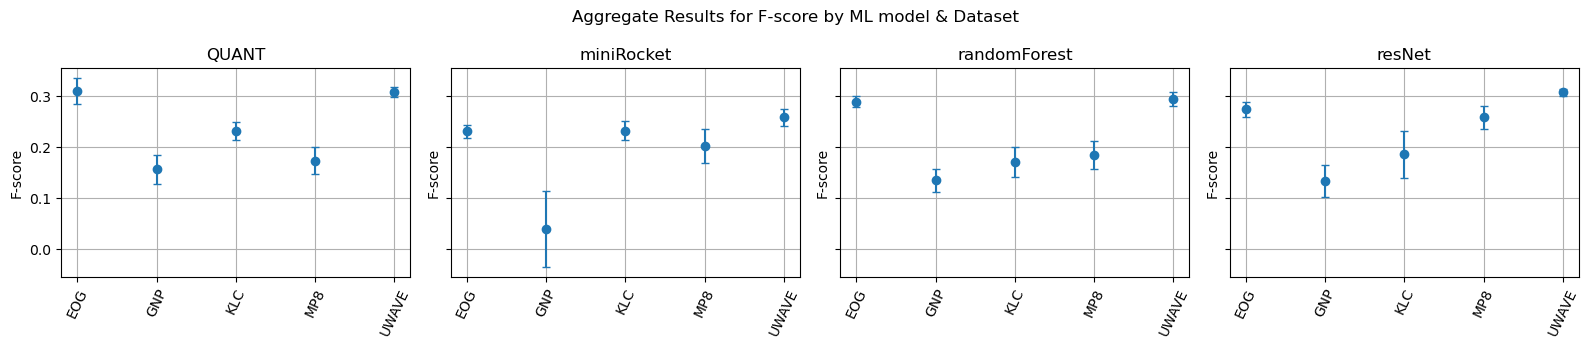

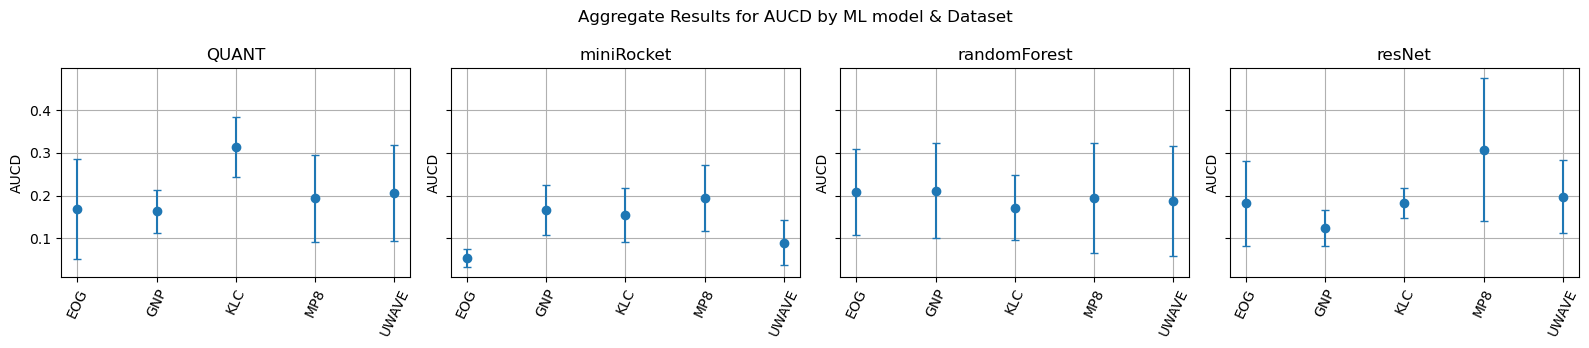

In [33]:
active_columns = columns_wo_result.copy()
active_columns.remove("Metric")
active_columns.remove("Normalization")
active_combinations = [["ML model", "Dataset"]] # list(combinations(active_columns, 2))  # [["Dataset", "ML model"]] #
metric_names = df["Metric"].unique() #["F-score", "AUCSE"]

for metric_name in metric_names:

    mask = (df["Metric"]==metric_name) & (df["Normalization"]=="default")
    df2 = df.loc[mask] # , ['Perturb', "Result"]
    # col_unique_lengths = []
    # for col in df2[active_columns]:
    #     col_unique_lengths.append(len(df2[col].unique()))
    # n_rows = len(active_combinations)
    # max_cols = np.max(col_unique_lengths)

    for column_names in active_combinations:
        if "Dataset" in column_names:
            df3 = df2.groupby([*column_names]).agg({'Result': ["mean", "std"]})
            index_levels = df3.index.levels
            df3.columns = df3.columns.get_level_values(1)
            df3 = df3.reset_index()

            n_cols = len(index_levels[0])

            fig, ax = plt.subplots(1, n_cols, figsize = (4*n_cols, 3.5), sharex=True, sharey=True) #dpi

            for j, column_name in enumerate(index_levels[0]):
                mask4 = df3[column_names[0]]==column_name
                df4 = df3.loc[mask4, [column_names[1], "mean", "std"]]
                df4 = df4.set_index(column_names[1])

                df4_mean = df4["mean"]
                df4_std = df4["std"]
                
                ax[j].errorbar(df4.index, df4_mean.values, df4_std.values, linestyle='None', marker='o', capsize=3)
                ax[j].grid()
                ax[j].tick_params("x", rotation=65)
                ax[j].set_title(column_name)
                ax[j].set_ylabel(metric_name)

                fig_name = f"Aggregate Results for {metric_name} by {column_names[0]} & {column_names[1]}"
                fig.suptitle(fig_name)
                fig.tight_layout()
                #fig.savefig(images_path + "/combinations/" + fig_name + ".png") # , dpi=100


In [30]:
# perturbations matter on Kepler
# gunpoint minirocket
# kepler resnet

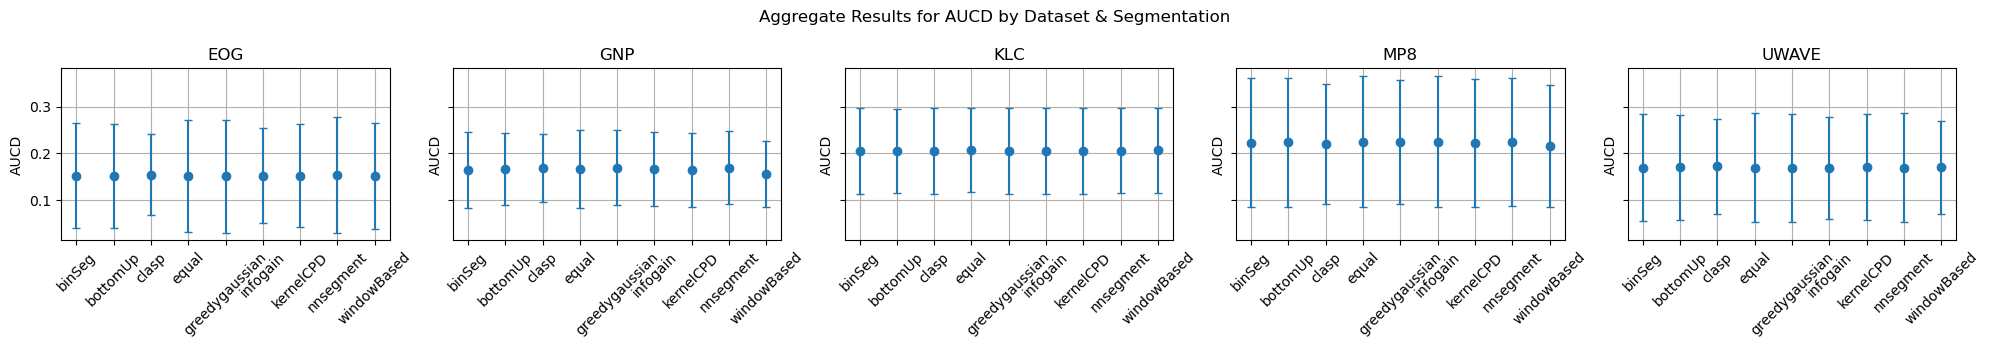

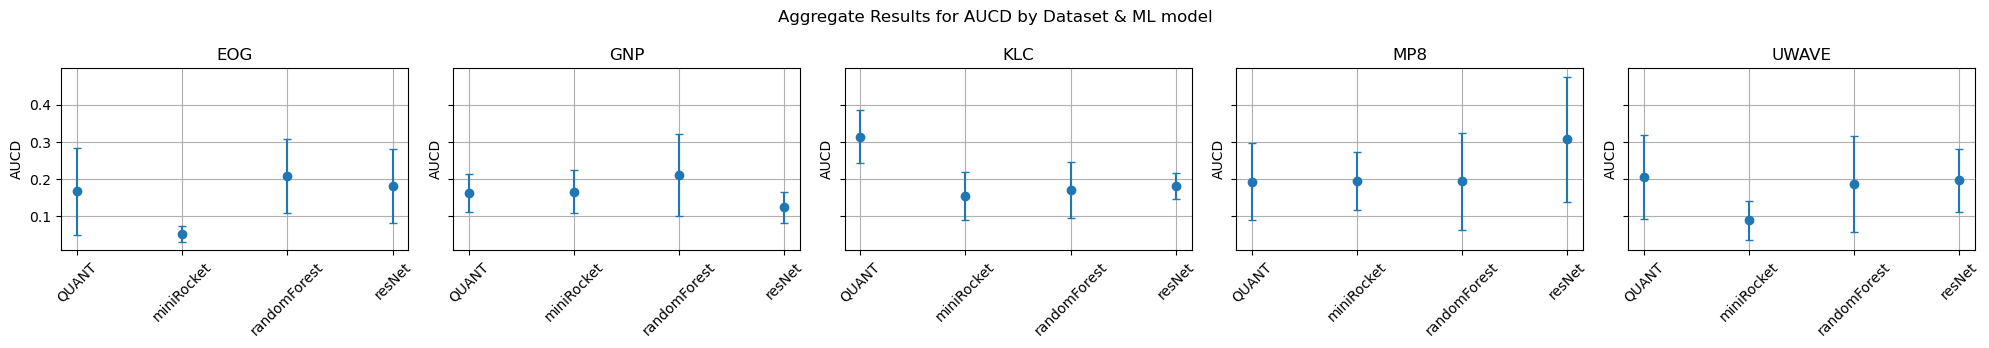

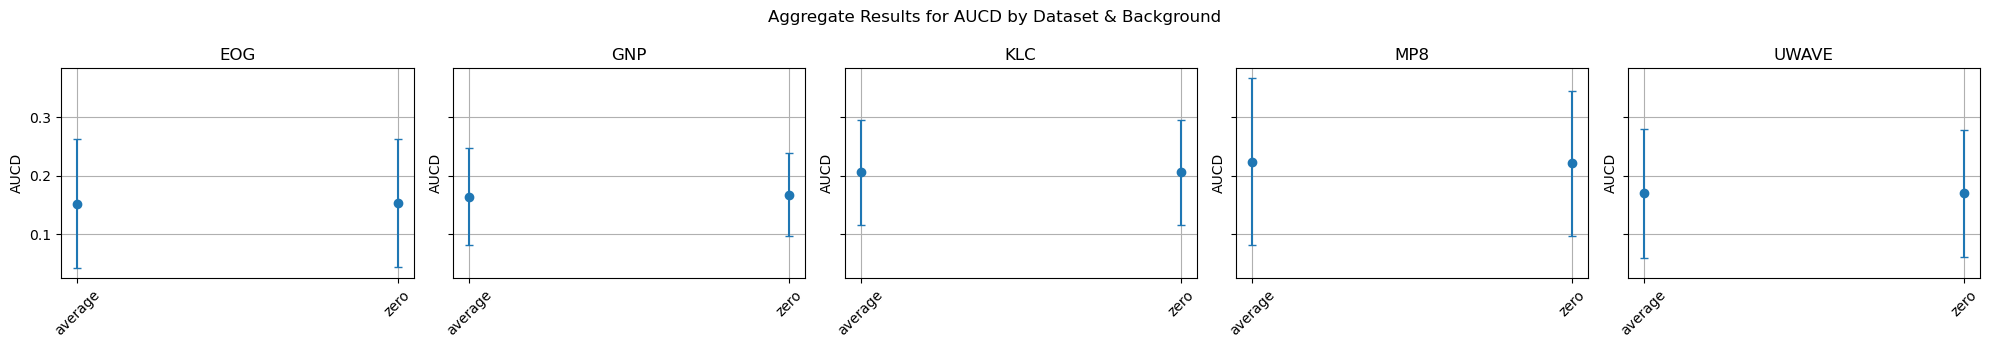

In [34]:
active_columns = columns_wo_result.copy()
active_columns.remove("Metric")
active_columns.remove("Normalization")
active_columns.remove("Perturb")
active_combinations = list(combinations(active_columns, 2)) # [["Dataset", "ML model"]] #
metric_name = "AUCD"


mask = (df["Metric"]==metric_name) & (df["Normalization"]=="default")
df2 = df.loc[mask] # , ['Perturb', "Result"]

for column_names in active_combinations:
    if "Dataset" in column_names:
        df3 = df2.groupby([*column_names]).agg({'Result': ["mean", "std"]})
        index_levels = df3.index.levels
        df3.columns = df3.columns.get_level_values(1)
        df3 = df3.reset_index()

        n_cols = len(index_levels[0])

        fig, ax = plt.subplots(1, n_cols, figsize = (4*n_cols, 3.5), sharex=True, sharey=True) #dpi

        for j, column_name in enumerate(index_levels[0]):
            mask4 = df3[column_names[0]]==column_name
            df4 = df3.loc[mask4, [column_names[1], "mean", "std"]]
            df4 = df4.set_index(column_names[1])

            df4_mean = df4["mean"]
            df4_std = df4["std"]
            
            ax[j].errorbar(df4.index, df4_mean.values, df4_std.values, linestyle='None', marker='o', capsize=3)
            ax[j].grid()
            ax[j].tick_params("x", rotation=45)
            ax[j].set_title(column_name)
            ax[j].set_ylabel(metric_name)

            fig_name = f"Aggregate Results for {metric_name} by {column_names[0]} & {column_names[1]}"
            fig.suptitle(fig_name)
            fig.tight_layout()
            #fig.savefig(images_path + "/combinations/" + fig_name + ".png") # , dpi=100

In [32]:
# sampling on resnet more consistent on auc deletion
# clasp worse on EOG pn both
# zero background worse on MP8

# Normalization

### For dataset and ML by each metric and segmentation, over background and perturb

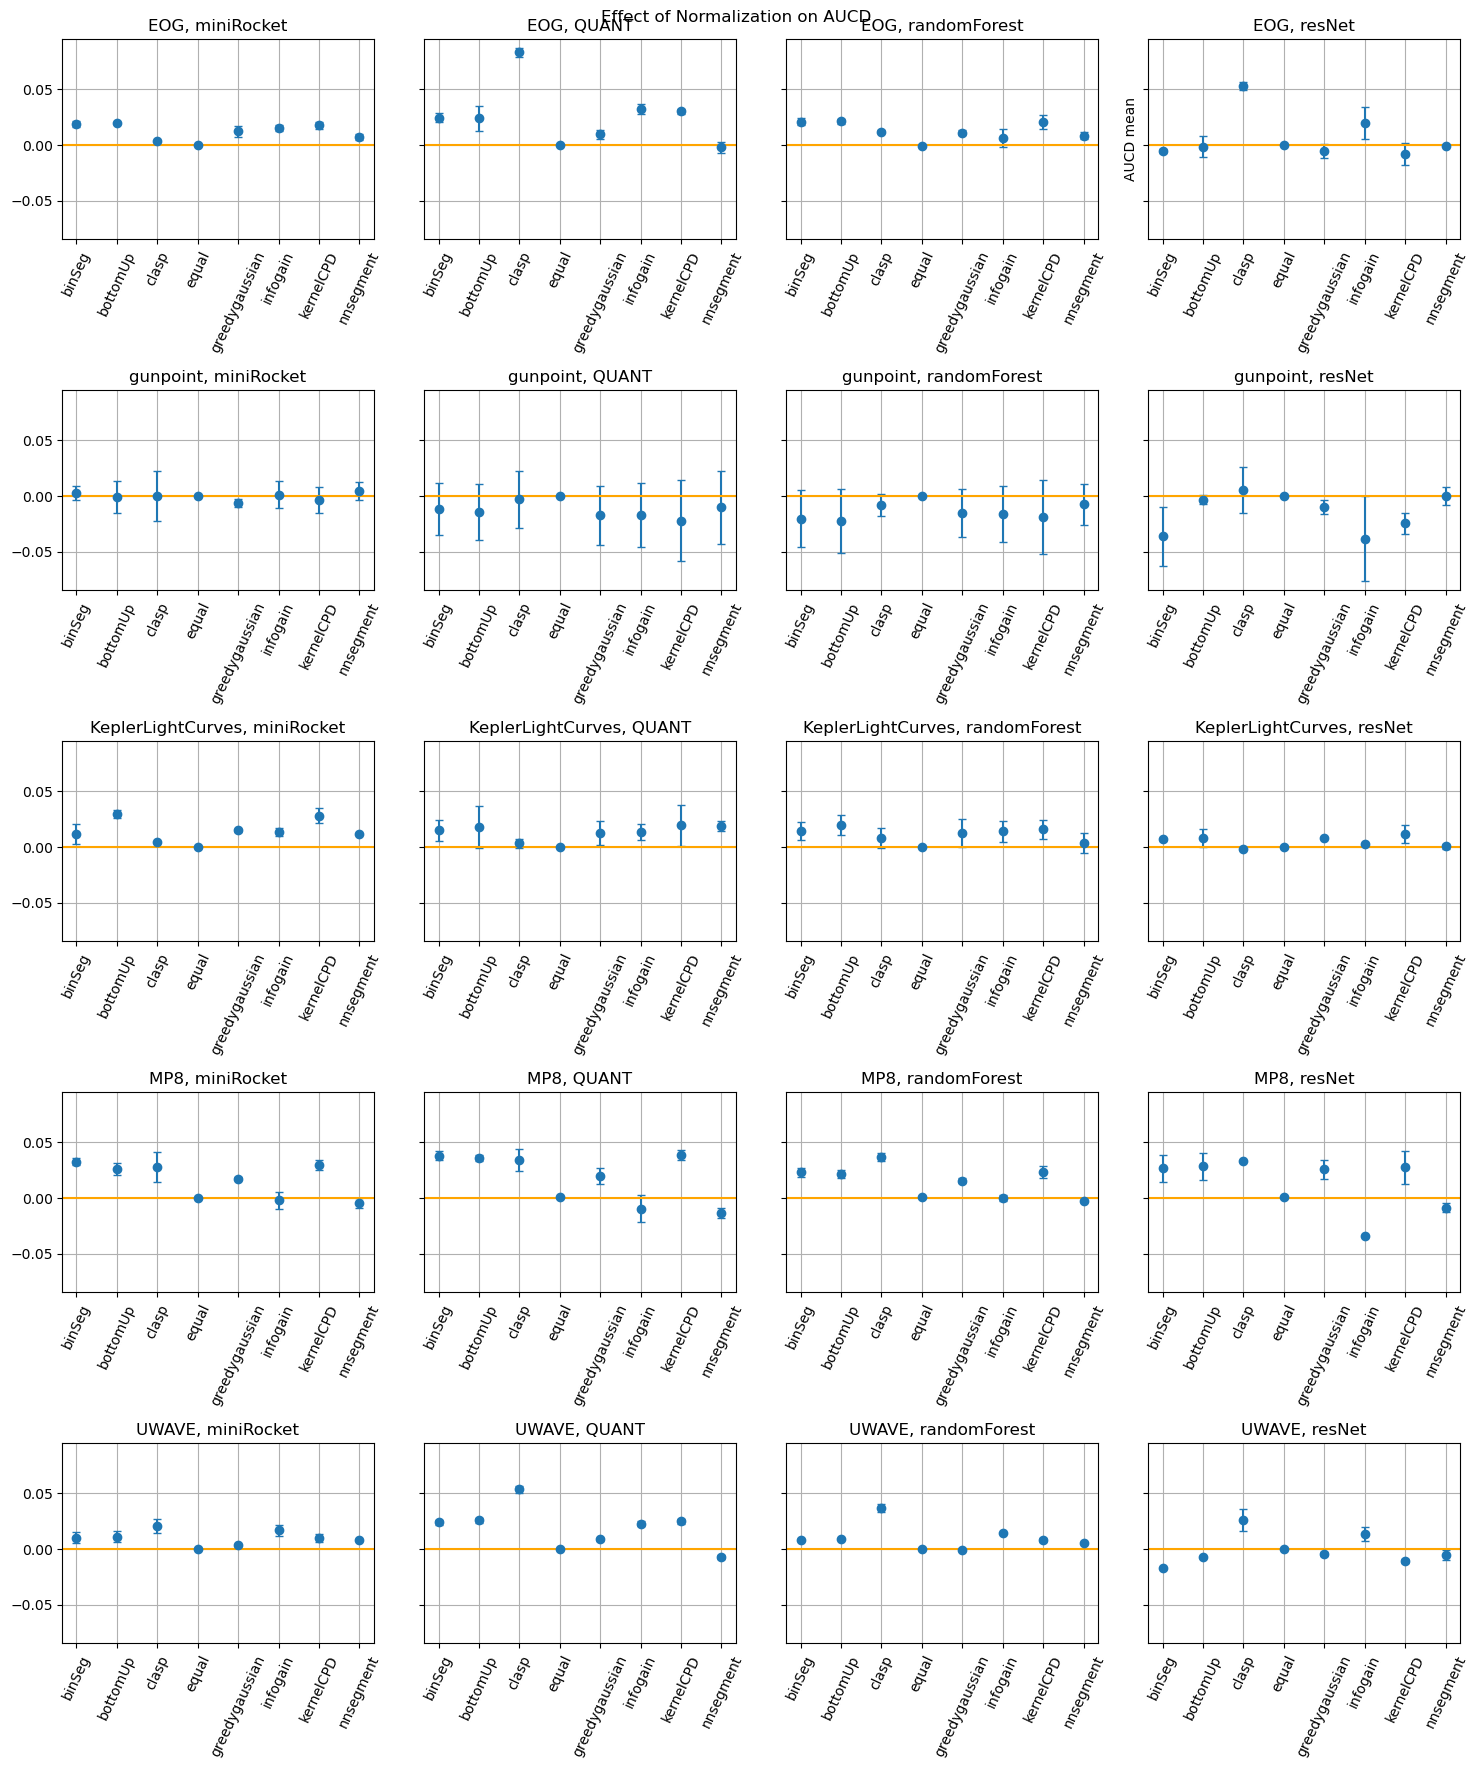

In [33]:
dataset_names = df["Dataset"].unique()
ml_model_names = df["ML model"].unique()
segmentation_names = df['Segmentation'].unique()

mask = (df["Metric"]=="AUCD") & (df["Perturb"]=="mean")# , ["Dataset", "Segmentation", "Perturb", "Result"]
df2 = df.loc[mask]
active_columns = columns_wo_result.copy()
active_columns.remove('Normalization')
pivoted = df2.pivot(index=active_columns, columns='Normalization', values='Result').reset_index()
pivoted['DIFF'] = pivoted['normalized'] - pivoted['default']
pivoted = pivoted.drop(columns=["default", "normalized"])

df3 = pivoted.groupby(["Dataset", "Segmentation", "ML model"]).agg({'DIFF': [("mean", "mean"), ("std", "std")]}).reset_index()

fig, ax = plt.subplots(len(dataset_names), len(ml_model_names), figsize = (15,18), sharex=False, sharey=True)

for i, dataset_name in enumerate(dataset_names):

    mask_dataset = (df3["Dataset"]==dataset_name)
    df4 = df3.loc[mask_dataset]

    for j, ml_model_name in enumerate(ml_model_names):

        mask_ml = (df4["ML model"]==ml_model_name)
        df5 = df4.loc[mask_ml] # , ["Segmentation", 'DIFF']

        x = df5["Segmentation"].values
        means = df5[("DIFF", "mean")].values
        stds = df5[("DIFF", "std")].values

        yerr = stds

        ax[i, j].set_title(f"{dataset_name}, {ml_model_name}")
        ax[i, j].errorbar(x, means, yerr, linestyle='None', marker='o', capsize=3)
        ax[i, j].grid()
        ax[i, j].tick_params("x", rotation=65)
        ax[i, j].axhline(0.0, c="orange")

    ax[0, j].set_ylabel("AUCD mean")

fig.suptitle("Effect of Normalization on AUCD")
fig.tight_layout()

## Two-Factor Aggregate

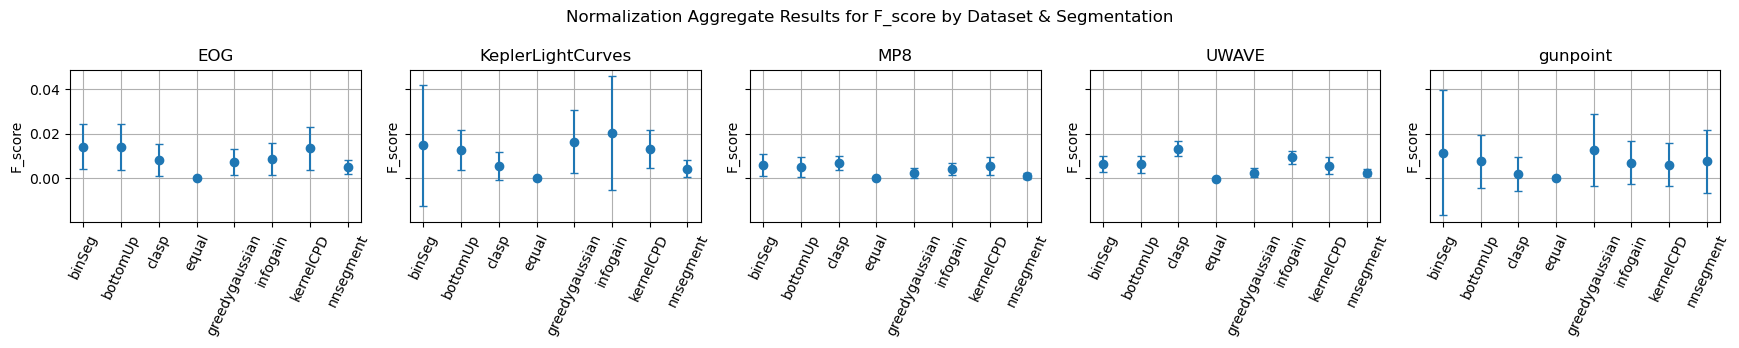

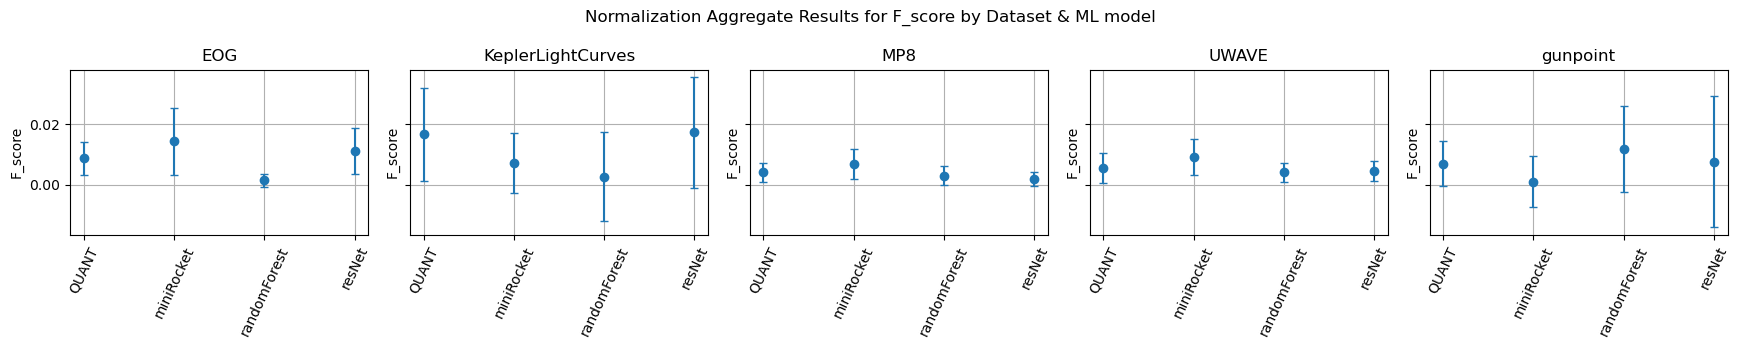

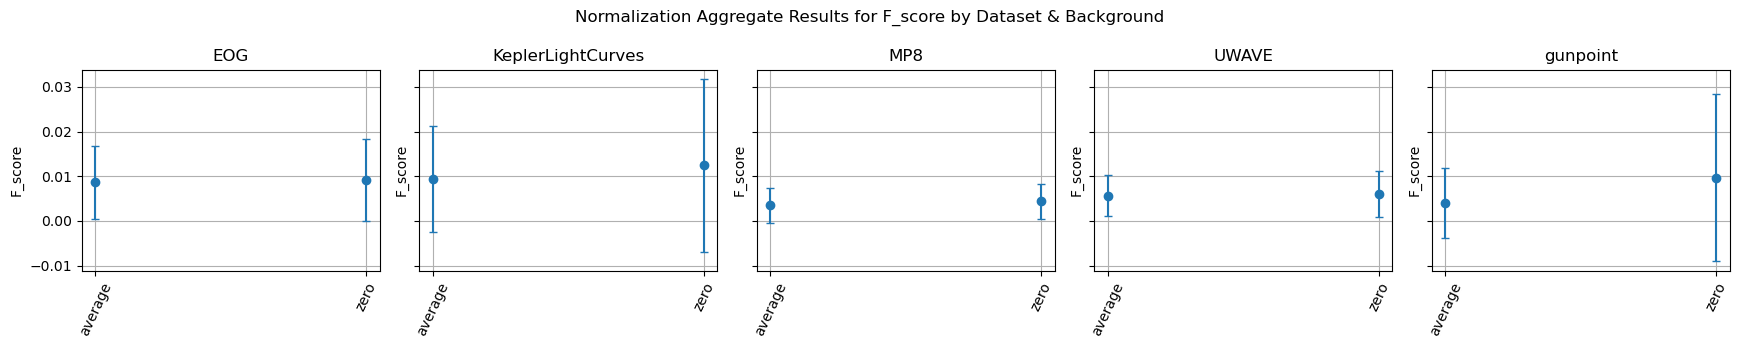

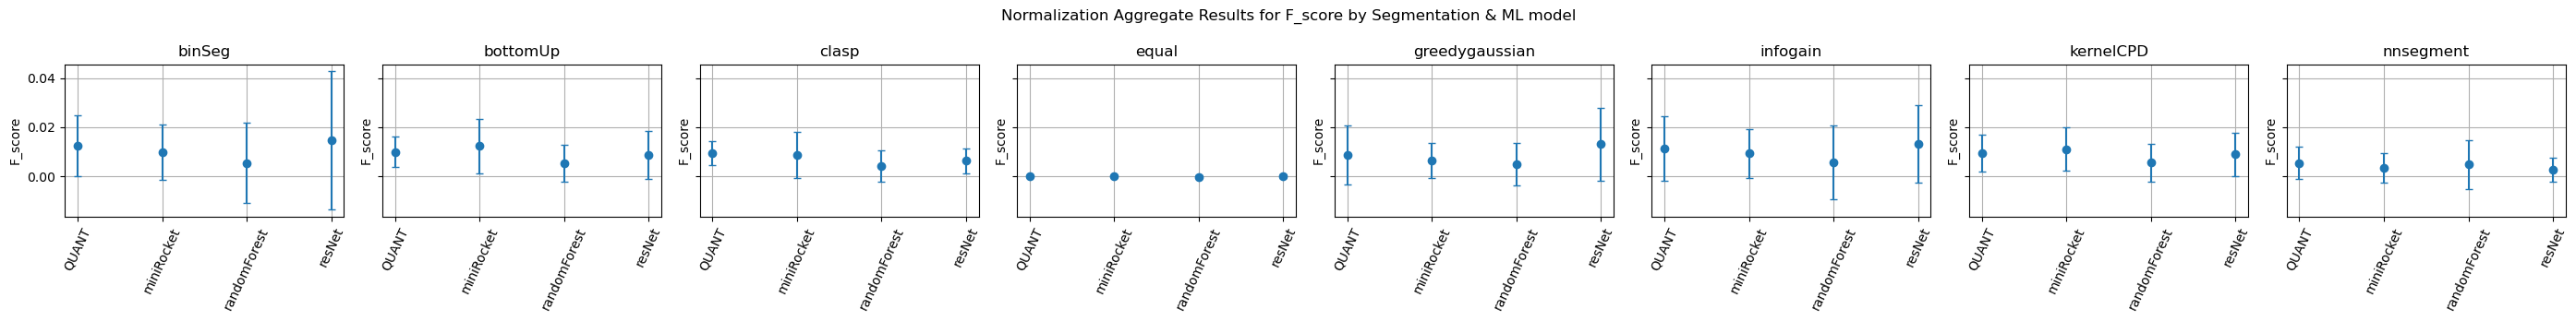

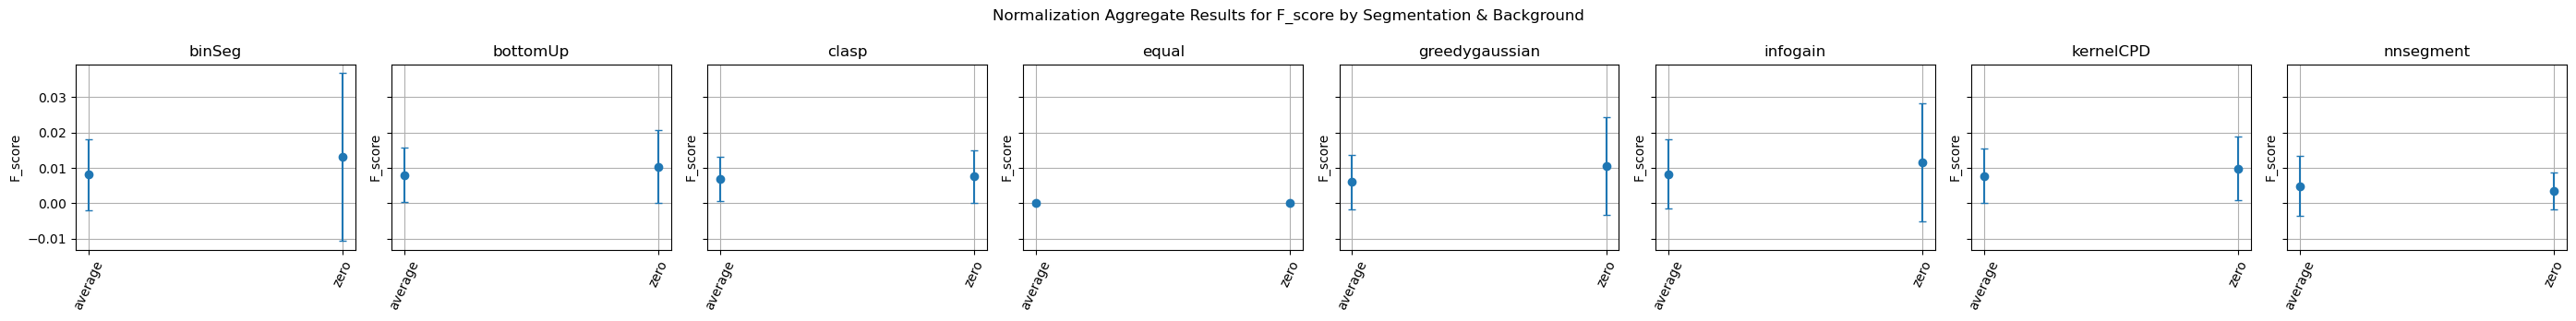

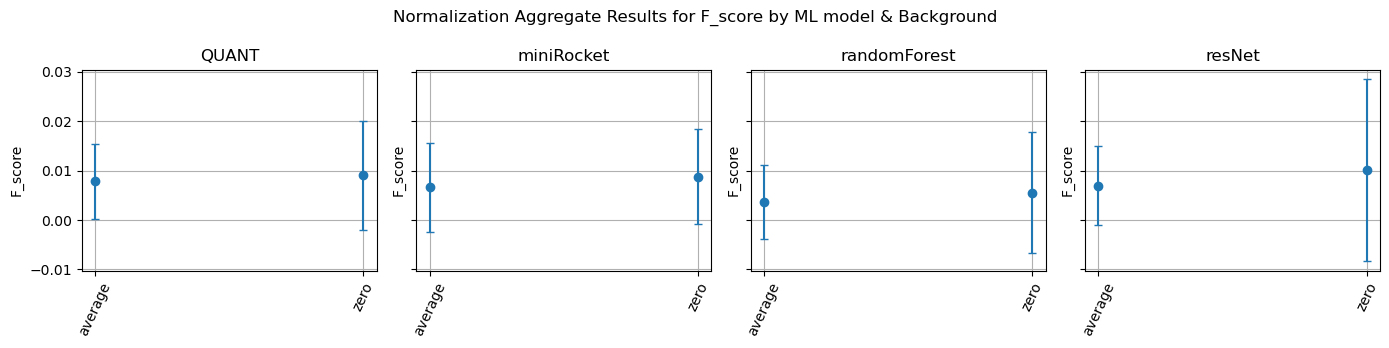

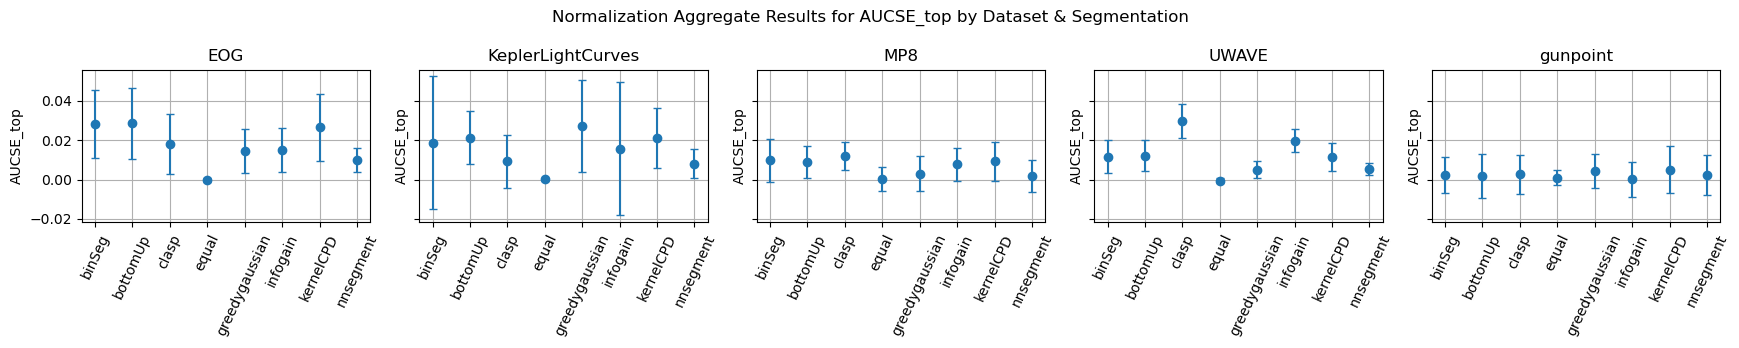

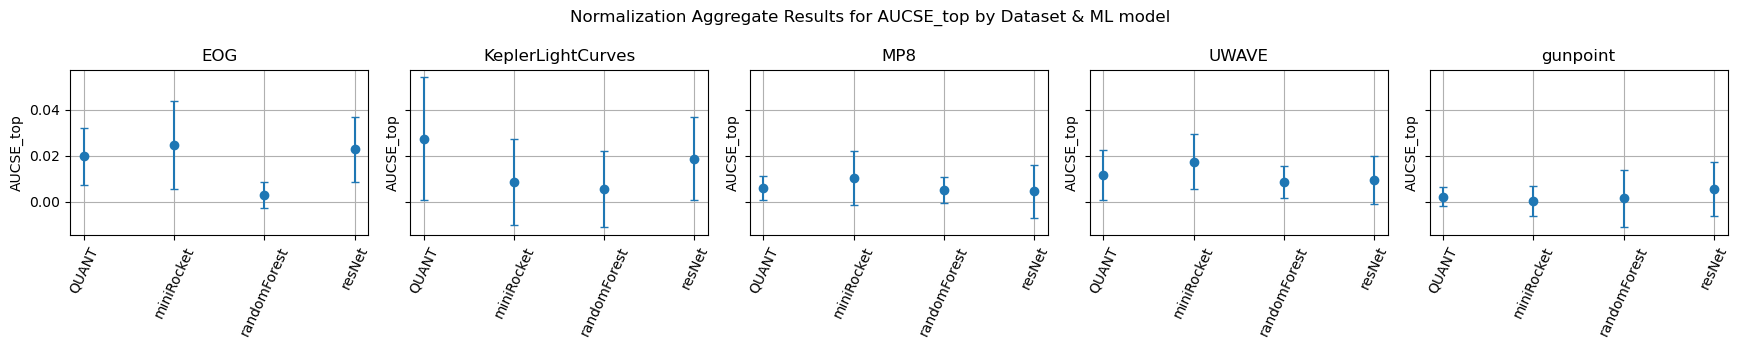

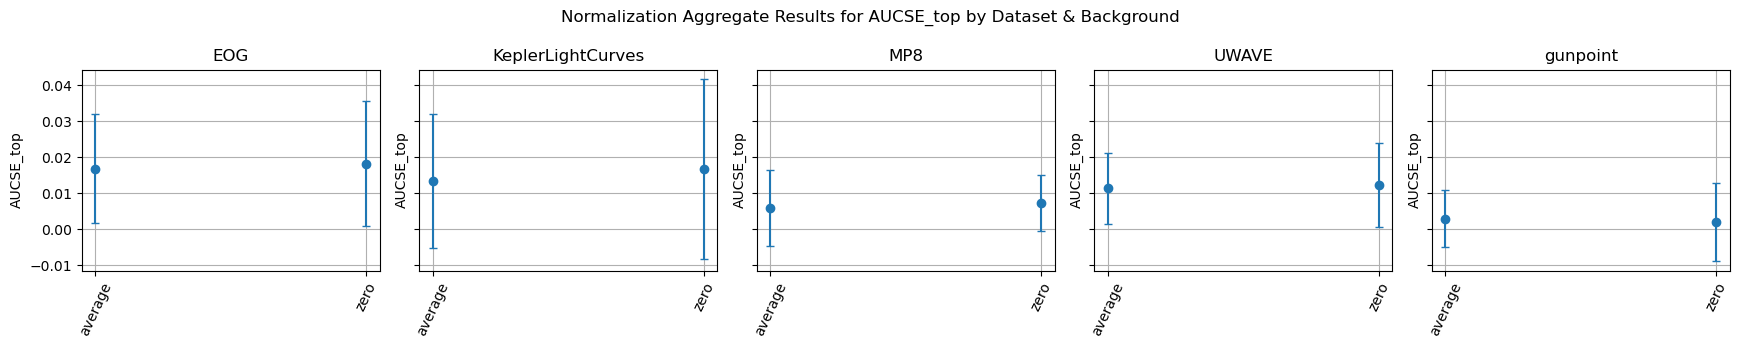

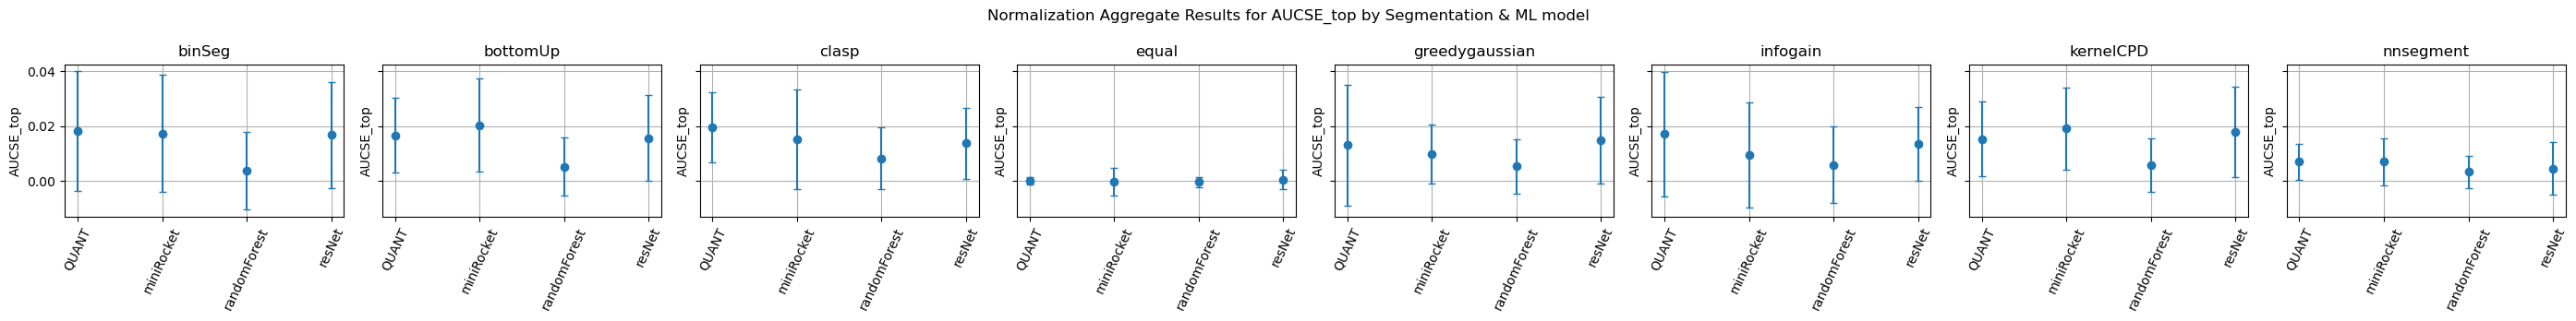

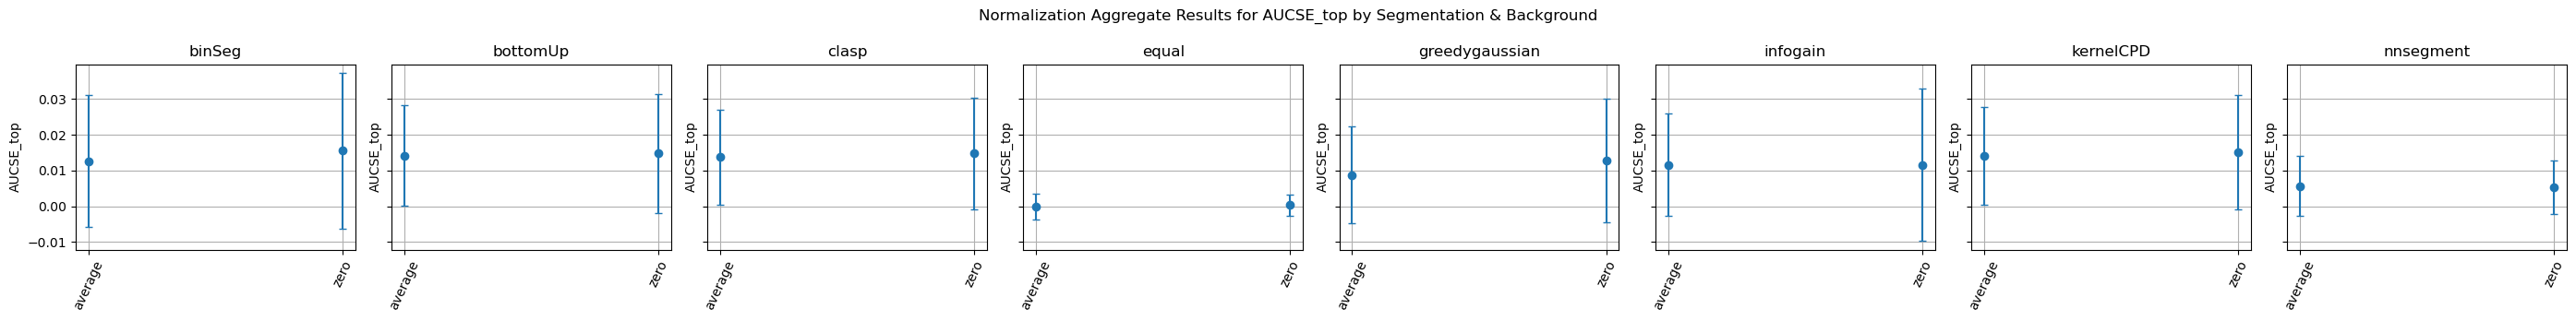

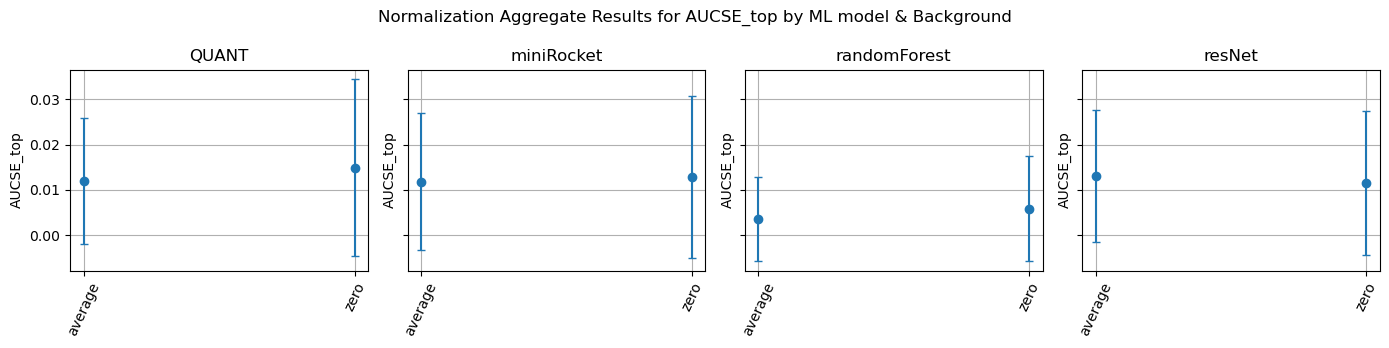

In [34]:
active_columns = columns_wo_result.copy()
active_columns.remove("Metric")
active_columns.remove("Normalization")
active_columns.remove("Perturb")
active_combinations = list(combinations(active_columns, 2)) # [["Dataset", "ML model"]] #
metric_names = ["F-score", "AUCSE"] # 


for metric_name in metric_names:

    mask = (df["Metric"]==metric_name)
    df2 = df.loc[mask]
    pivoted = df2.pivot(index=df2.columns.difference(['Normalization', "Result"]).tolist(), columns='Normalization', values='Result').reset_index()
    pivoted['Result'] = pivoted['normalized'] - pivoted['default']
    pivoted = pivoted.drop(columns=["default", "normalized"])

    for column_names in active_combinations:
        #column_names = column_names[::-1]
        df3 = pivoted.groupby([*column_names]).agg({'Result': ["mean", "std"]})
        index_levels = df3.index.levels
        df3.columns = df3.columns.get_level_values(1)
        df3 = df3.reset_index()
        # print(dataset_name, ml_model_name, metric_name, column_names[0], column_names[1])
        # print(index_levels)

        n_cols = len(index_levels[0])

        fig, ax = plt.subplots(1, n_cols, figsize = (3.5*n_cols, 3.5), sharex=True, sharey=True) #dpi

        for j, column_name in enumerate(index_levels[0]):
            mask4 = df3[column_names[0]]==column_name
            df4 = df3.loc[mask4, [column_names[1], "mean", "std"]]
            df4 = df4.set_index(column_names[1])

            df4_mean = df4["mean"]
            df4_std = df4["std"]
            
            ax[j].errorbar(df4.index, df4_mean.values, df4_std.values, linestyle='None', marker='o', capsize=3)
            ax[j].grid()
            ax[j].tick_params("x", rotation=65)
            ax[j].set_title(column_name)
            ax[j].set_ylabel(metric_name)

            fig_name = f"Normalization Aggregate Results for {metric_name} by {column_names[0]} & {column_names[1]}"
            fig.suptitle(fig_name)
            fig.tight_layout()
            fig.savefig(images_path + "/normalization/" + fig_name + ".png") # , dpi=100

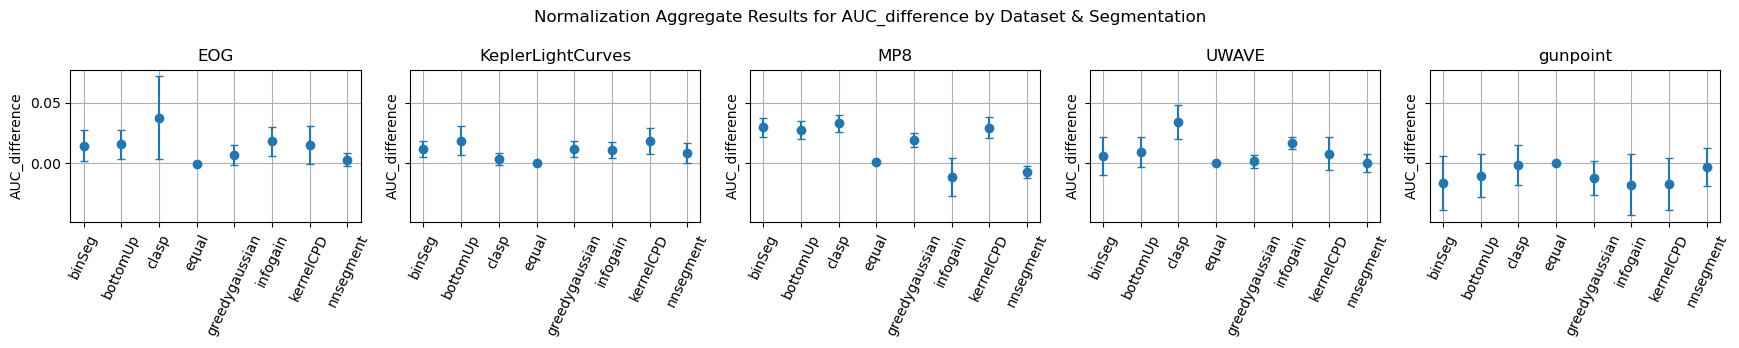

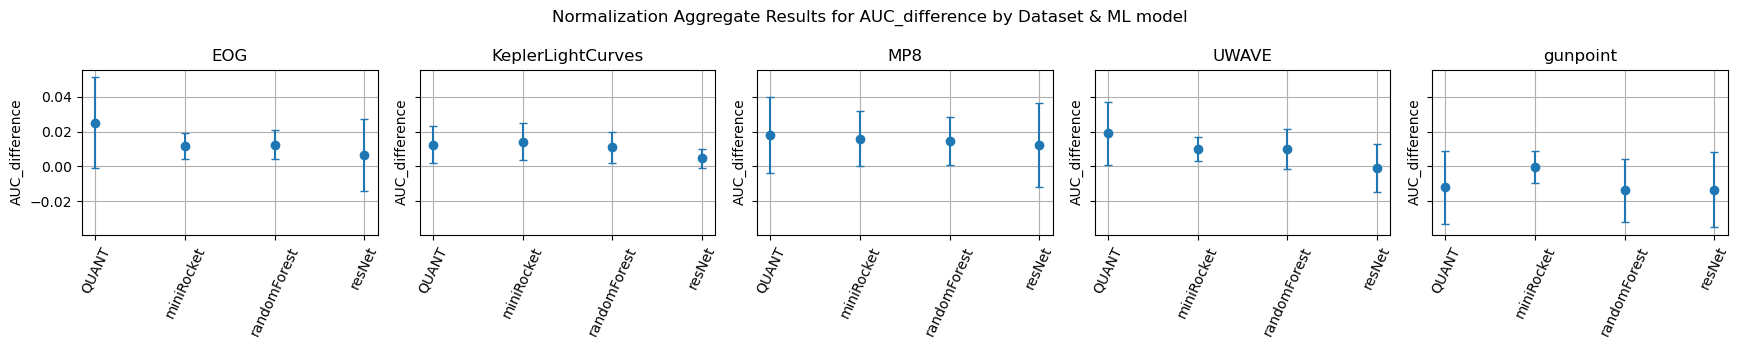

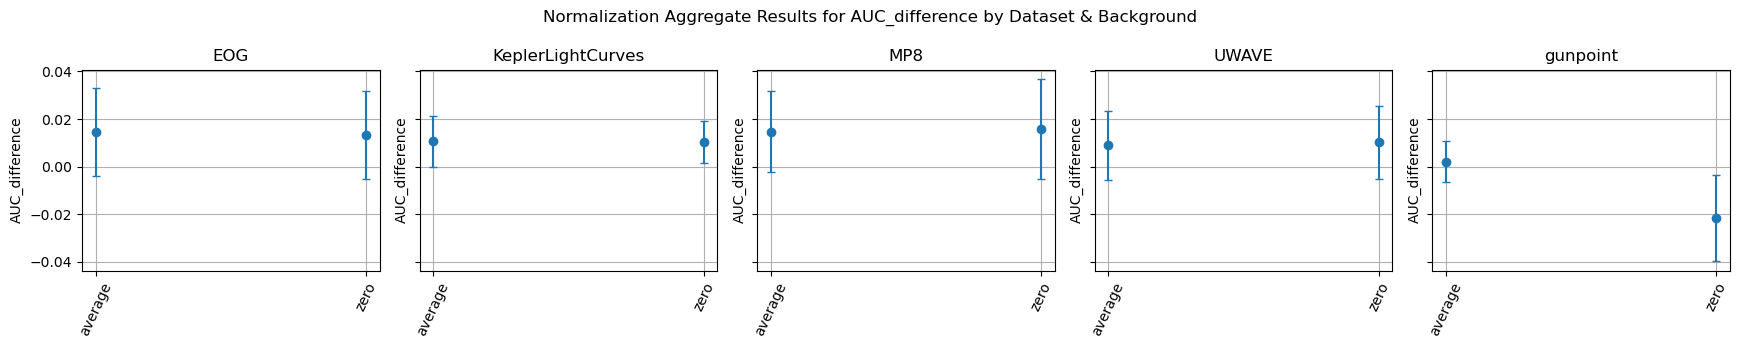

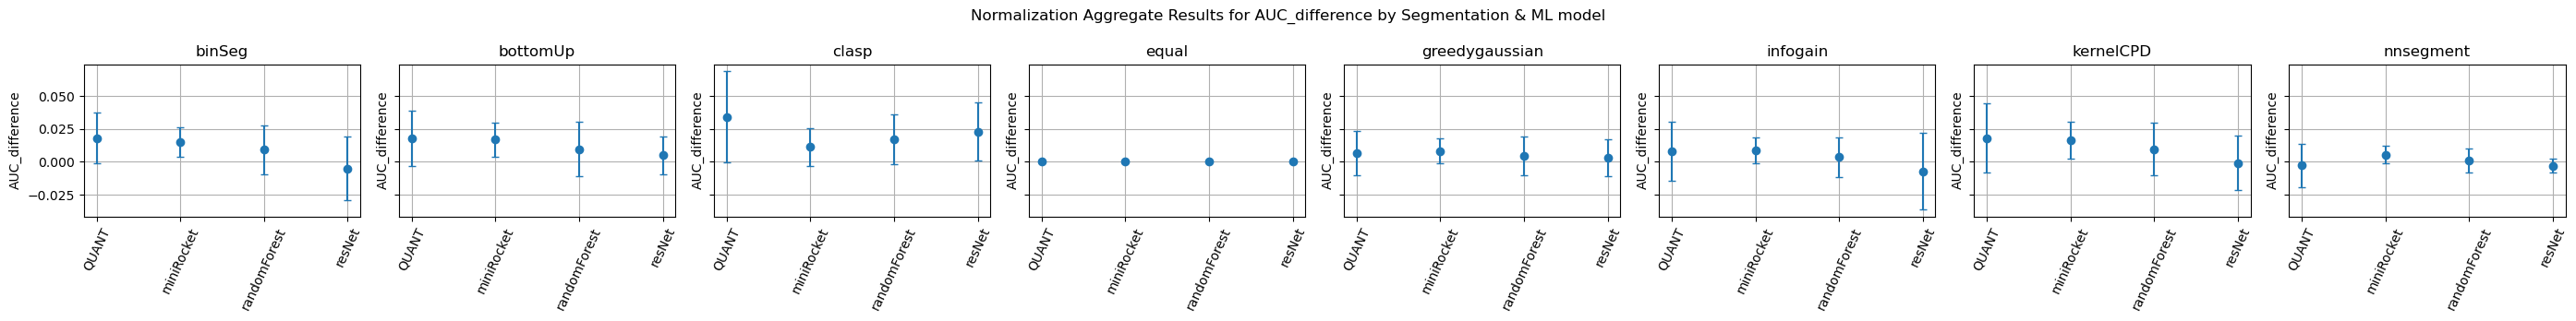

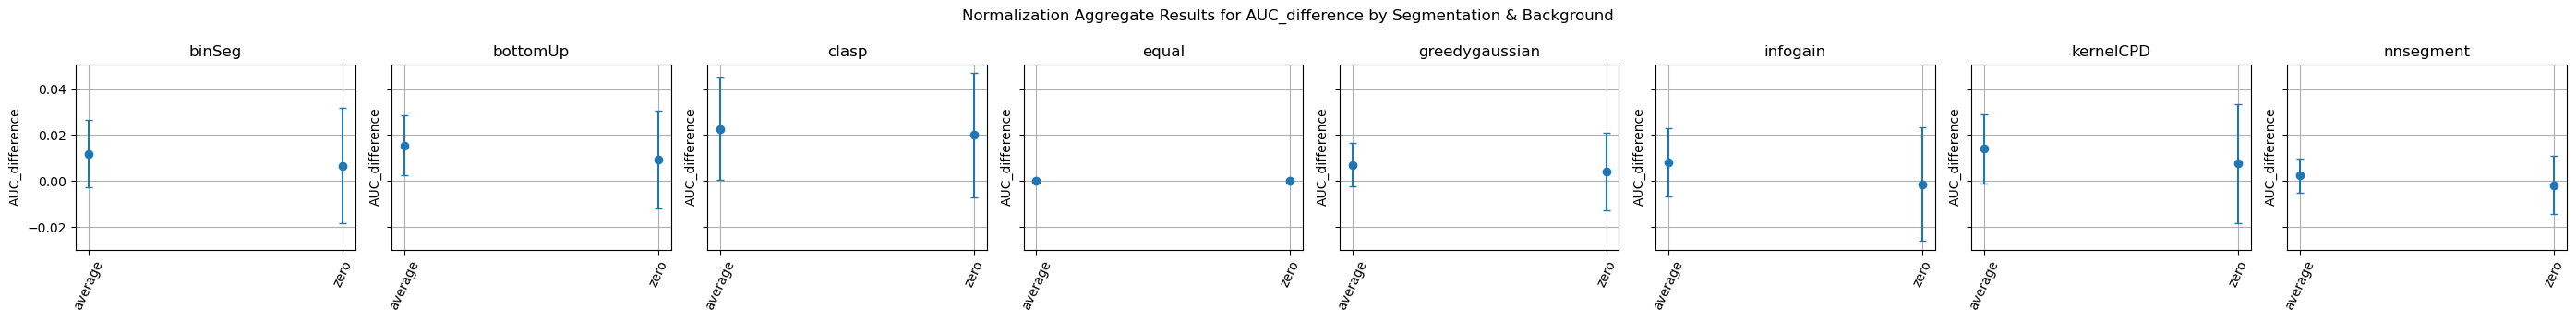

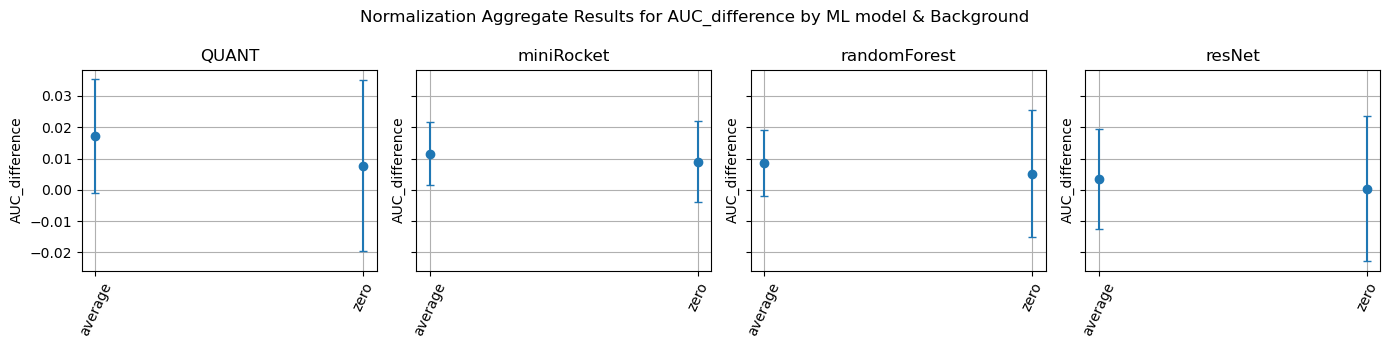

In [35]:
active_columns = columns_wo_result.copy()
active_columns.remove("Metric")
active_columns.remove("Normalization")
active_columns.remove("Perturb")
active_combinations = list(combinations(active_columns, 2)) # [["Dataset", "ML model"]] #
metric_name = 'AUCD'

mask = (df["Metric"]==metric_name)
df2 = df.loc[mask]

# values_to_delete = ['insertion_std', 'deletion_std']
# filtered_df = df2[~df2['Perturb'].isin(values_to_delete)]
# pivoted = filtered_df.pivot_table(index=filtered_df.columns.difference(['Perturb', 'Result']).tolist(), columns='Perturb', values='Result').reset_index()
# pivoted['Result'] = pivoted['insertion_mean'] - pivoted['deletion_mean']
# pivoted['Perturb'] = 'mean'
# df2 = pivoted.drop(['deletion_mean', 'insertion_mean'], axis=1)

pivoted = df2.pivot(index=df2.columns.difference(['Normalization', "Result"]).tolist(), columns='Normalization', values='Result').reset_index()
pivoted['Result'] = pivoted['normalized'] - pivoted['default']
pivoted = pivoted.drop(columns=["default", "normalized"])

for column_names in active_combinations:
    #column_names = column_names[::-1]
    df3 = pivoted.groupby([*column_names]).agg({'Result': ["mean", "std"]})
    index_levels = df3.index.levels
    df3.columns = df3.columns.get_level_values(1)
    df3 = df3.reset_index()
    # print(dataset_name, ml_model_name, metric_name, column_names[0], column_names[1])
    # print(index_levels)

    n_cols = len(index_levels[0])

    fig, ax = plt.subplots(1, n_cols, figsize = (3.5*n_cols, 3.5), sharex=True, sharey=True) #dpi

    for j, column_name in enumerate(index_levels[0]):
        mask4 = df3[column_names[0]]==column_name
        df4 = df3.loc[mask4, [column_names[1], "mean", "std"]]
        df4 = df4.set_index(column_names[1])

        df4_mean = df4["mean"]
        df4_std = df4["std"]
        
        ax[j].errorbar(df4.index, df4_mean.values, df4_std.values, linestyle='None', marker='o', capsize=3)
        ax[j].grid()
        ax[j].tick_params("x", rotation=65)
        ax[j].set_title(column_name)
        ax[j].set_ylabel(metric_name)

        fig_name = f"Normalization Aggregate Results for {metric_name} by {column_names[0]} & {column_names[1]}"
        fig.suptitle(fig_name)
        fig.tight_layout()
        fig.savefig(images_path + "/normalization/" + fig_name + ".png") # , dpi=100

In [36]:
0/0

ZeroDivisionError: division by zero

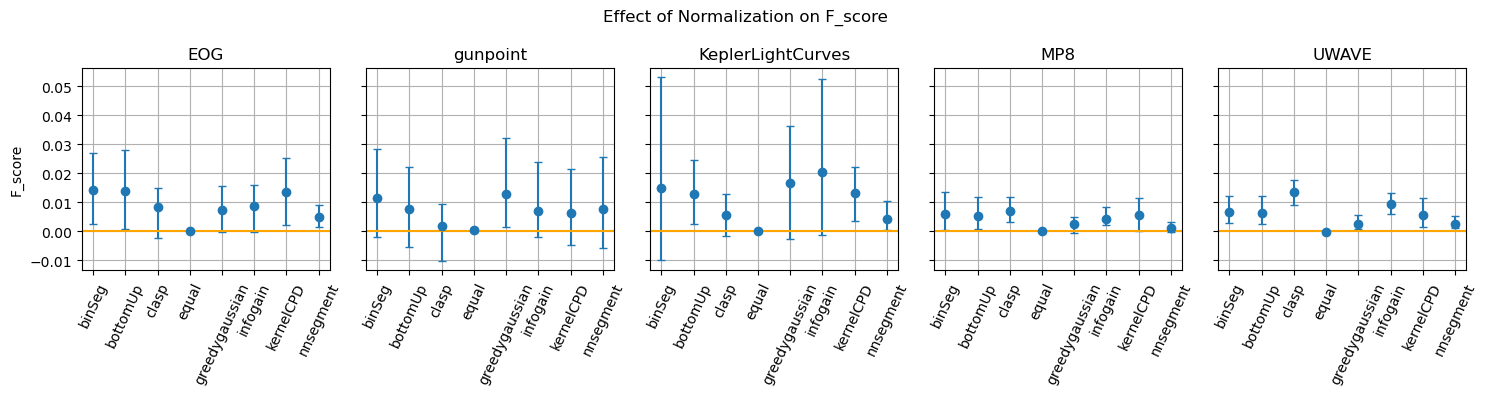

In [41]:
dataset_names = df["Dataset"].unique()
segmentation_names = df['Segmentation'].unique()

mask = (df["Metric"]=="F_score") # , ["Dataset", "Segmentation", "Perturb", "Result"]
df2 = df.loc[mask]
active_columns = columns_wo_result.copy()
active_columns.remove('Normalization')
pivoted = df2.pivot(index=active_columns, columns='Normalization', values='Result').reset_index()
pivoted['DIFF'] = pivoted['normalized'] - pivoted['default']


df3 = pivoted.groupby(["Dataset", "Segmentation"]).agg({'DIFF': [("mean", "mean"), ("q10", lambda x: x.quantile(0.10)), ("q90", lambda x: x.quantile(0.90))]}).reset_index()

fig, ax = plt.subplots(1, len(dataset_names), figsize = (15,4), sharex=False, sharey=True)

for i, dataset_name in enumerate(dataset_names):

    mask_dataset = (df3["Dataset"]==dataset_name)
    df4 = df3.loc[mask_dataset, ["Segmentation", 'DIFF']]

    x = df4["Segmentation"].values
    means = df4[("DIFF", "mean")].values
    q10 = df4[("DIFF", "q10")].values
    q90 = df4[("DIFF", "q90")].values

    yerr = [means - q10, q90 - means]

    ax[i].set_title(dataset_name)
    ax[i].errorbar(x, means, yerr, linestyle='None', marker='o', capsize=3)
    ax[i].grid()
    ax[i].tick_params("x", rotation=65)
    ax[i].axhline(0.0, c="orange")

ax[0].set_ylabel("F-score")

fig.suptitle("Effect of Normalization on F-score")
fig.tight_layout()

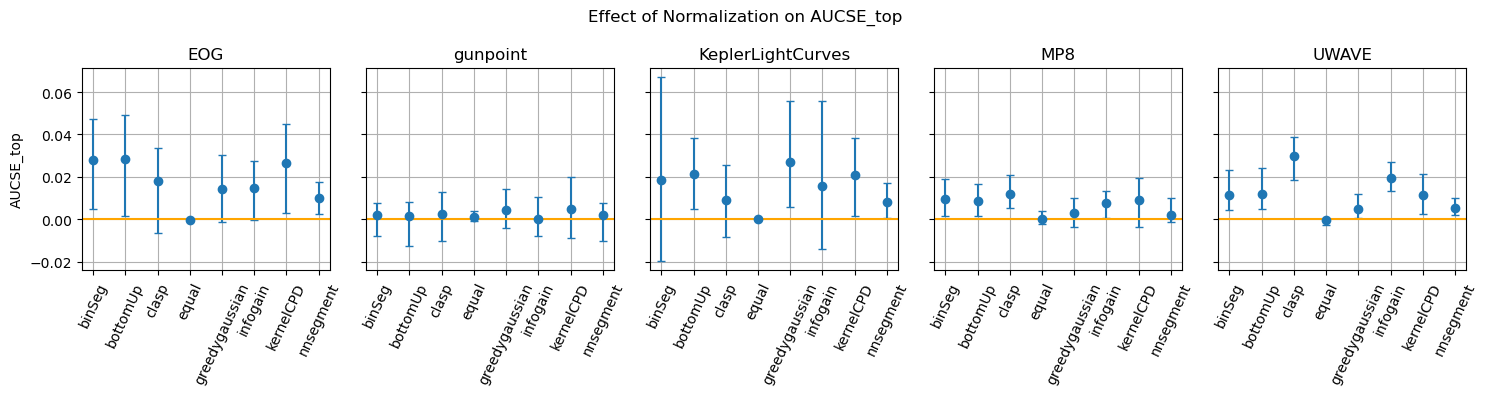

In [42]:
dataset_names = df["Dataset"].unique()
segmentation_names = df['Segmentation'].unique()

mask = (df["Metric"]=="AUCSE") # , ["Dataset", "Segmentation", "Perturb", "Result"]
df2 = df.loc[mask]
active_columns = columns_wo_result.copy()
active_columns.remove('Normalization')
pivoted = df2.pivot(index=active_columns, columns='Normalization', values='Result').reset_index()
pivoted['DIFF'] = pivoted['normalized'] - pivoted['default']


df3 = pivoted.groupby(["Dataset", "Segmentation"]).agg({'DIFF': [("mean", "mean"), ("q10", lambda x: x.quantile(0.10)), ("q90", lambda x: x.quantile(0.90))]}).reset_index()

fig, ax = plt.subplots(1, len(dataset_names), figsize = (15,4), sharex=False, sharey=True)

for i, dataset_name in enumerate(dataset_names):

    mask_dataset = (df3["Dataset"]==dataset_name)
    df4 = df3.loc[mask_dataset, ["Segmentation", 'DIFF']]

    x = df4["Segmentation"].values
    means = df4[("DIFF", "mean")].values
    q10 = df4[("DIFF", "q10")].values
    q90 = df4[("DIFF", "q90")].values

    yerr = (means - q10, np.where((q90>means), q90 - means, 0.0))

    ax[i].set_title(dataset_name)
    ax[i].errorbar(x, means, yerr, linestyle='None', marker='o', capsize=3)
    ax[i].grid()
    ax[i].tick_params("x", rotation=65)
    ax[i].axhline(0.0, c="orange")

ax[0].set_ylabel("AUCSE")

fig.suptitle("Effect of Normalization on AUCSE_top")
fig.tight_layout()

In [ ]:
0/0

# Specific Dataset/Metric Combinations Aggregate analysis

In [39]:
from itertools import combinations

In [40]:
pairs_of_interest = [("KeplerLightCurves", "resNet"), ("gunpoint", "miniRocket"), ("MP8", "miniRocket")]

In [41]:
columns_wo_result

['Dataset',
 'Segmentation',
 'ML model',
 'Background',
 'Normalization',
 'Perturb',
 'Metric']

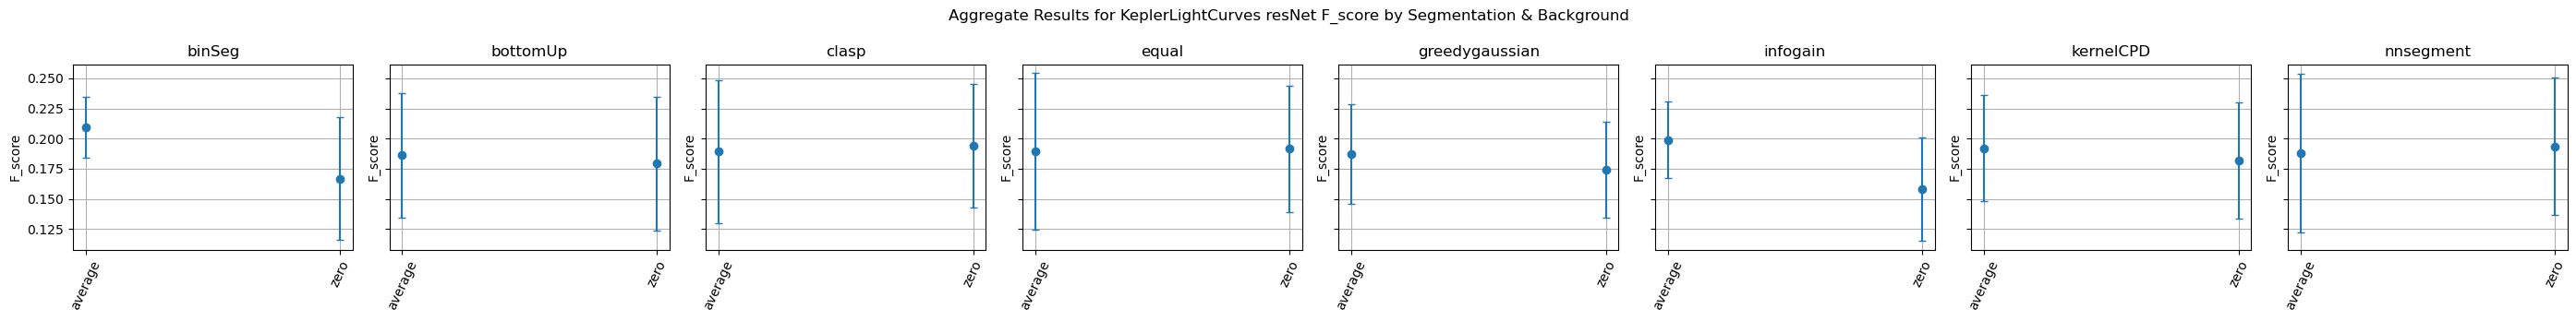

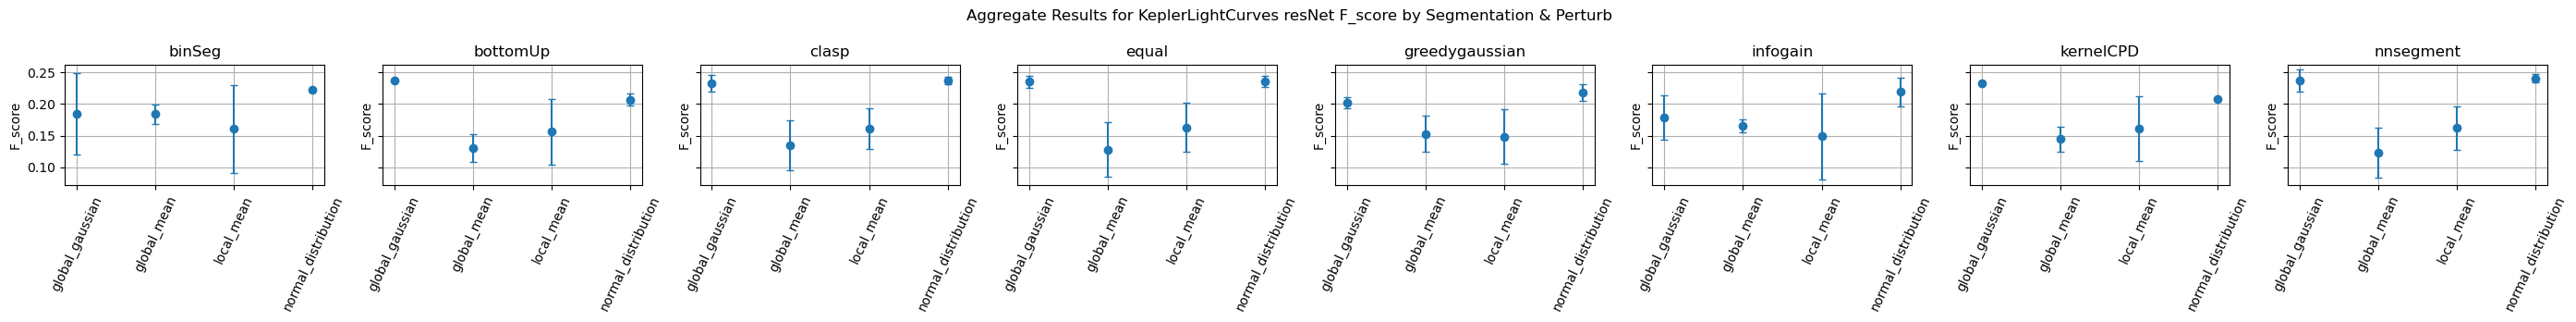

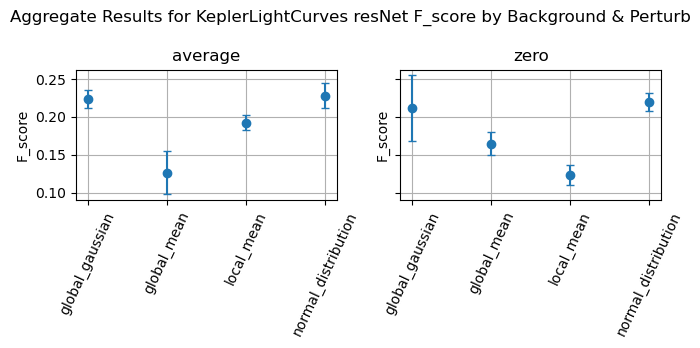

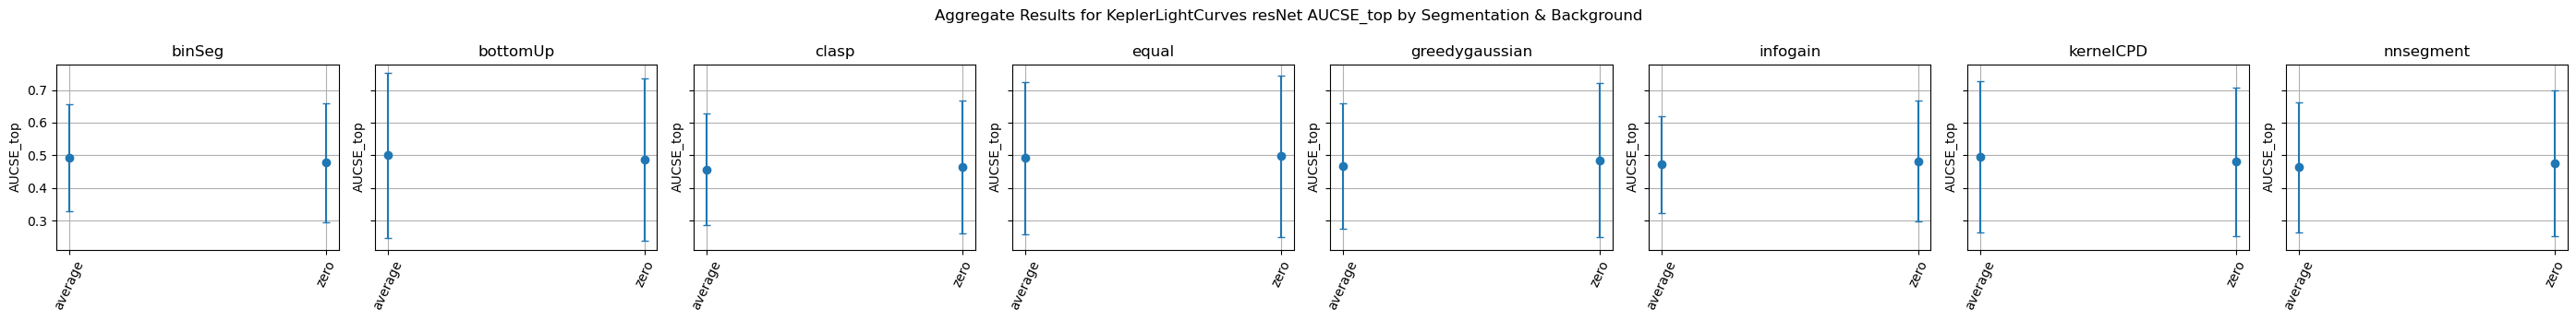

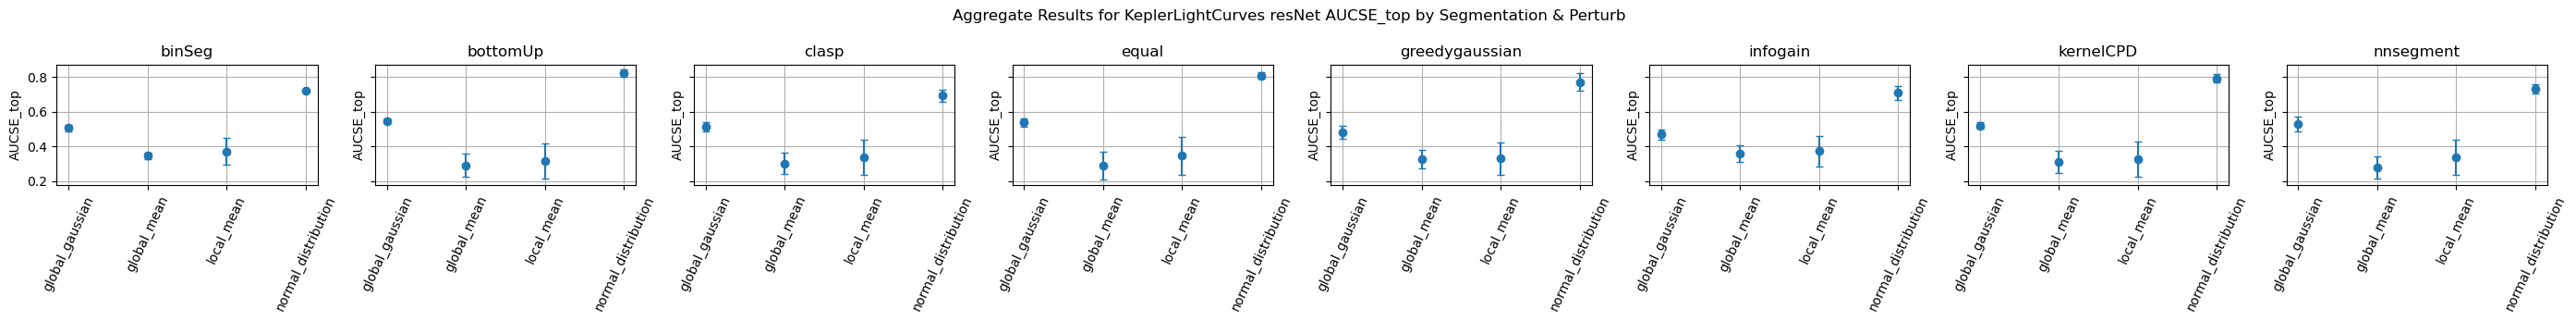

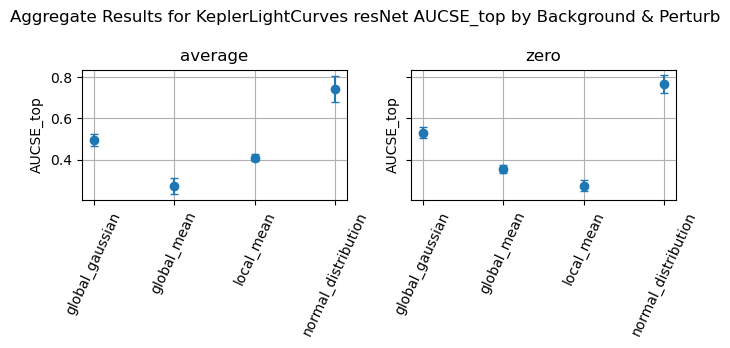

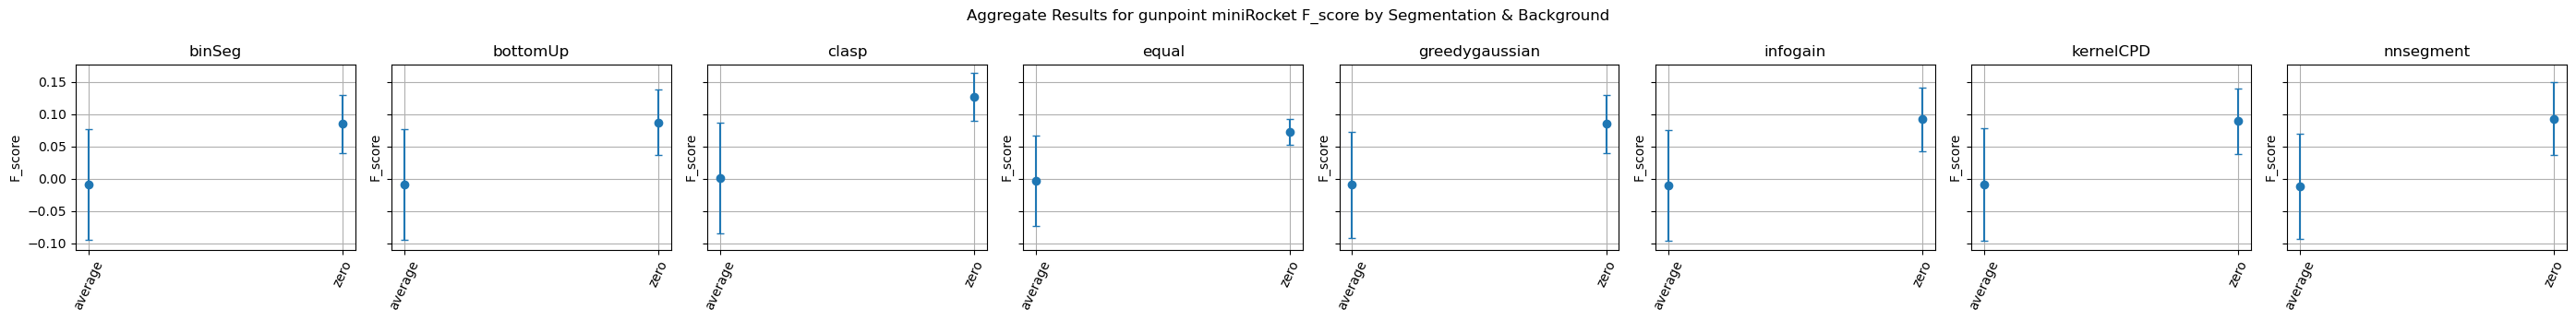

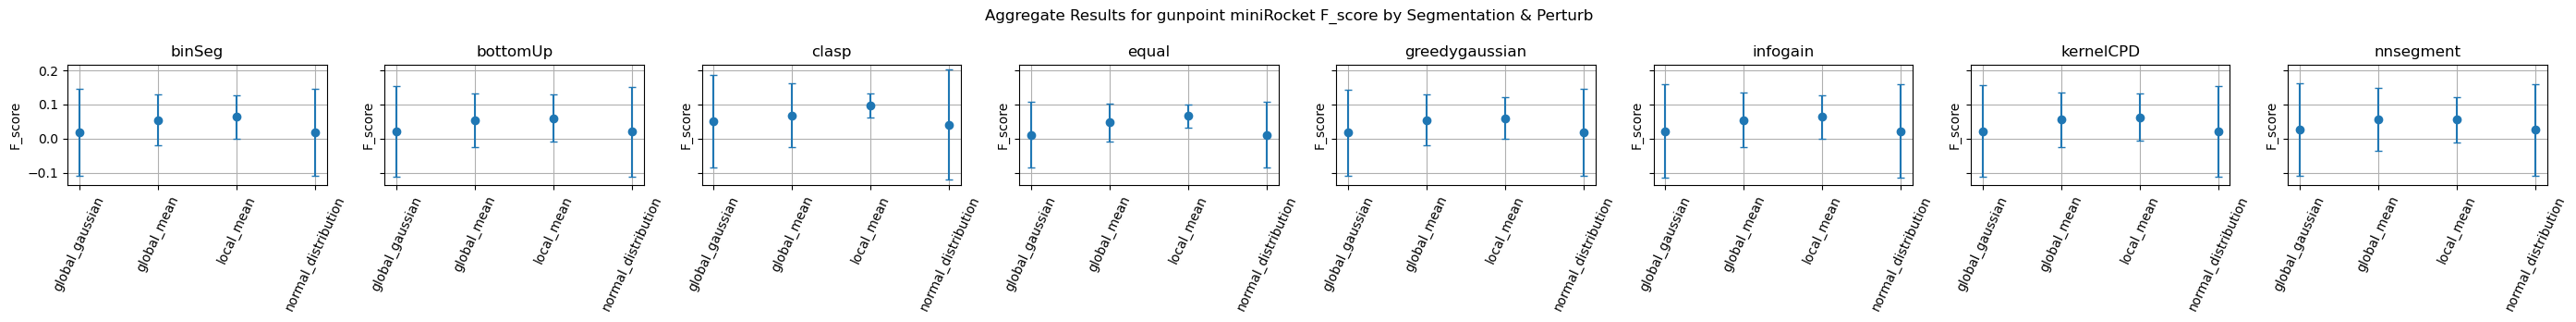

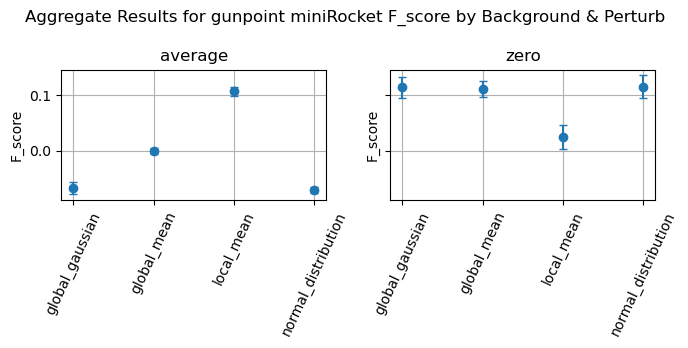

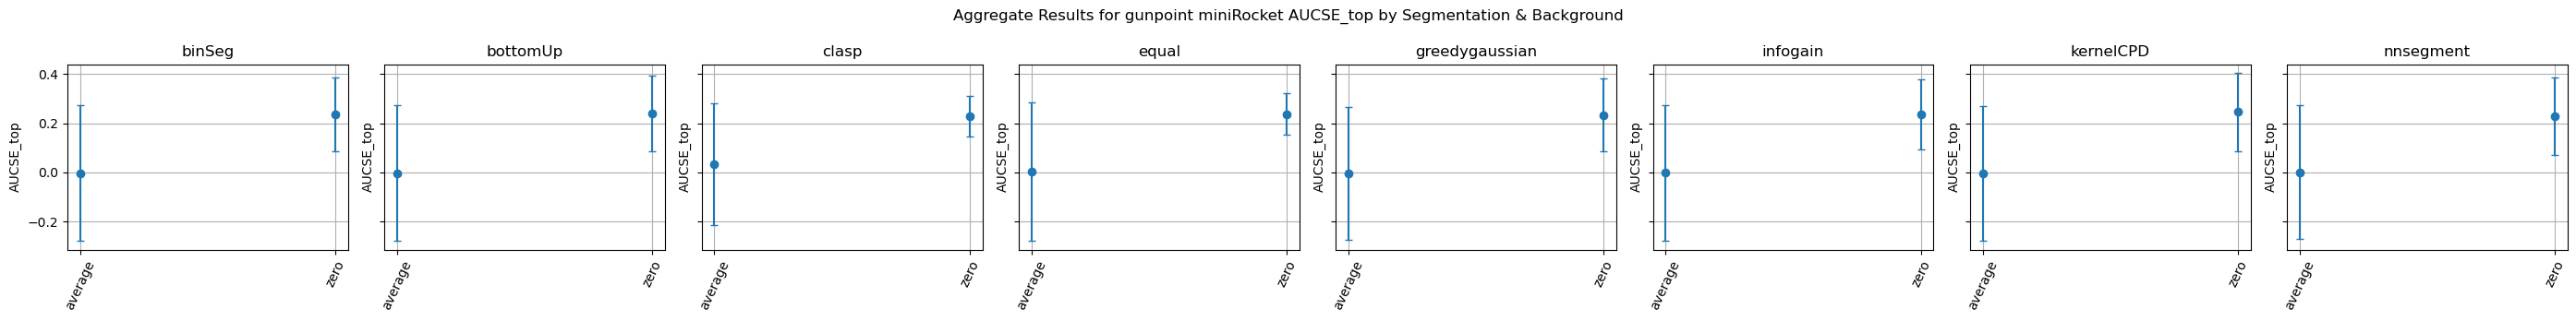

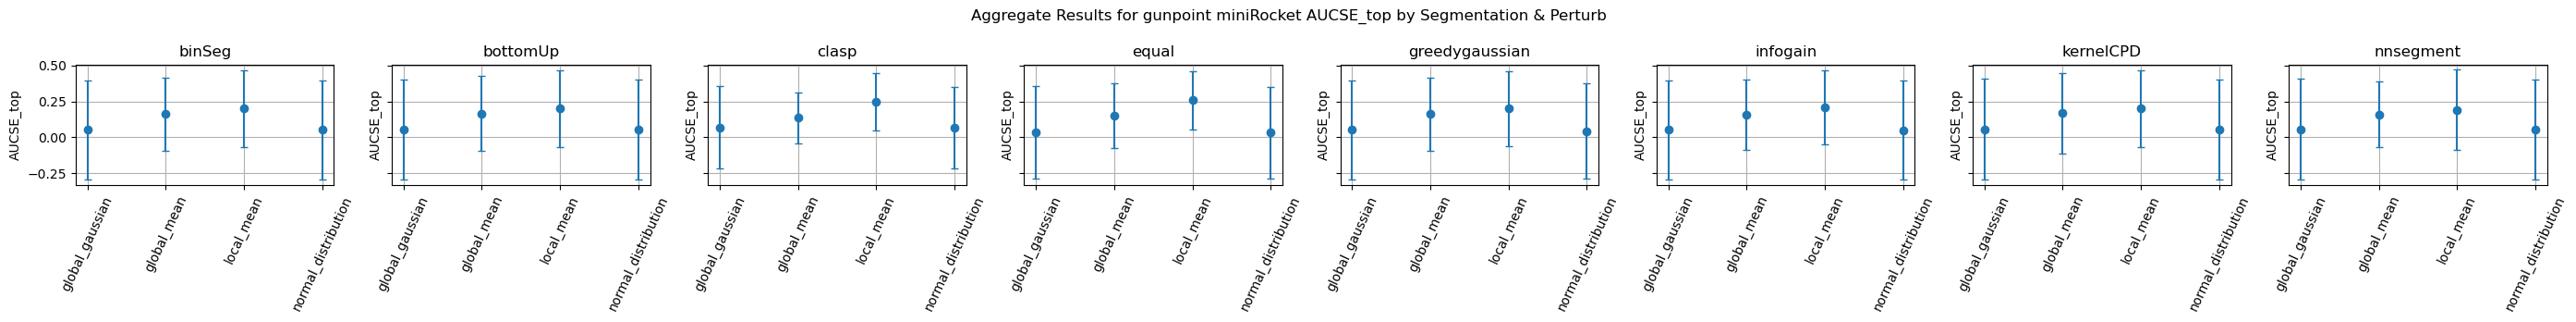

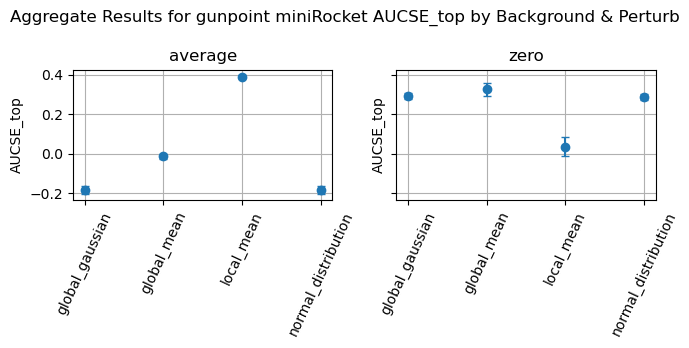

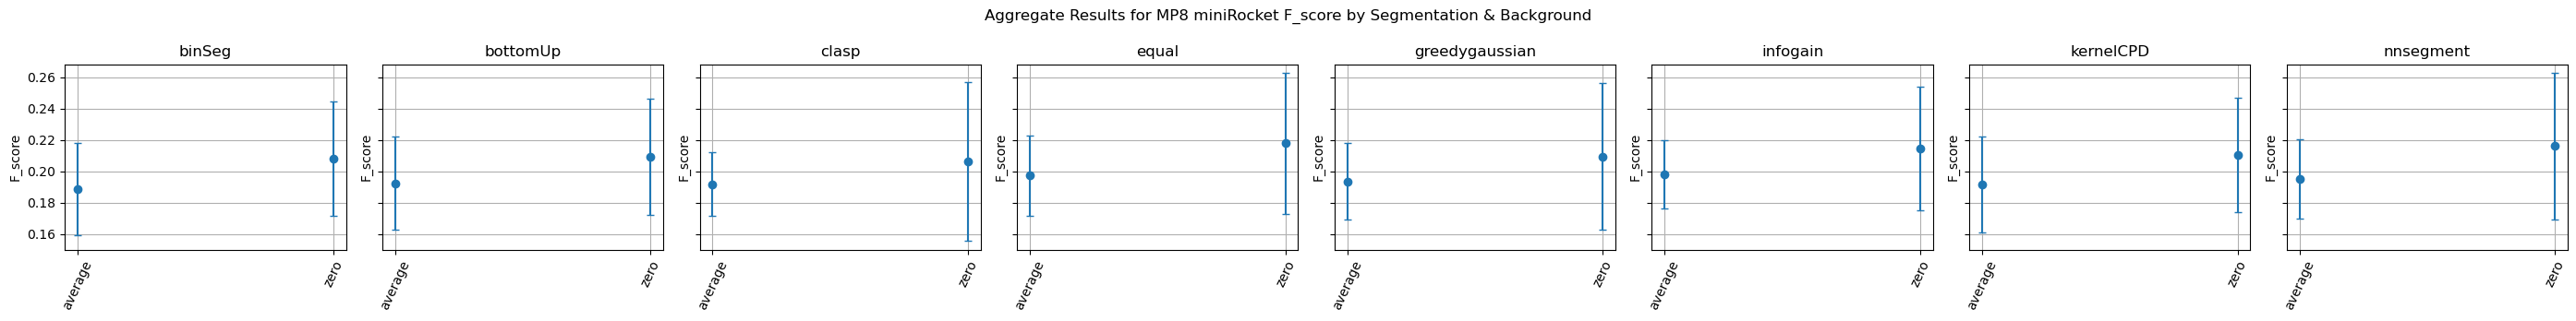

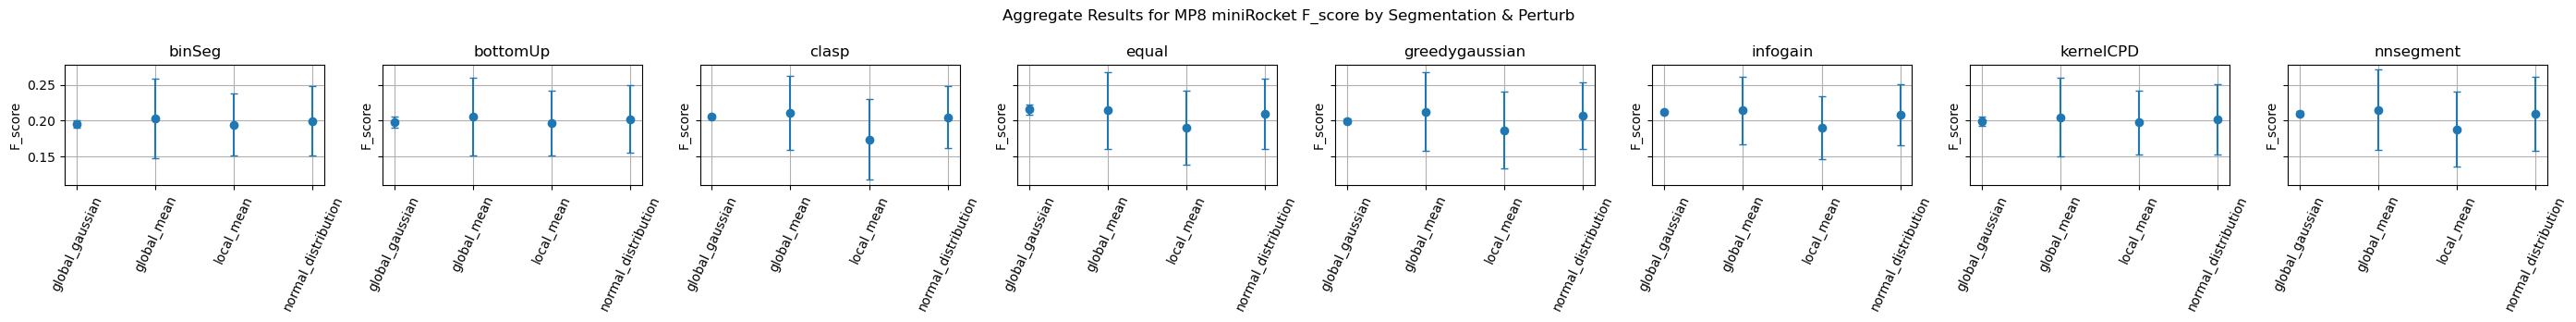

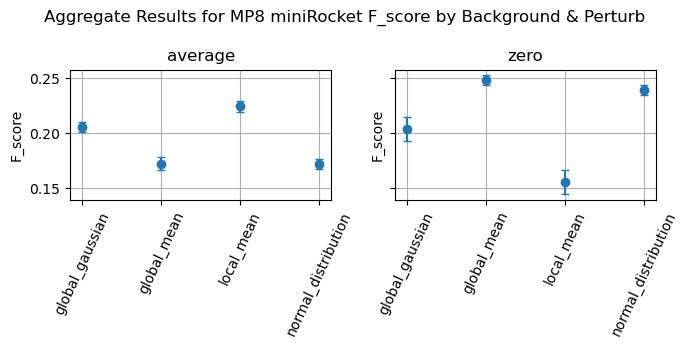

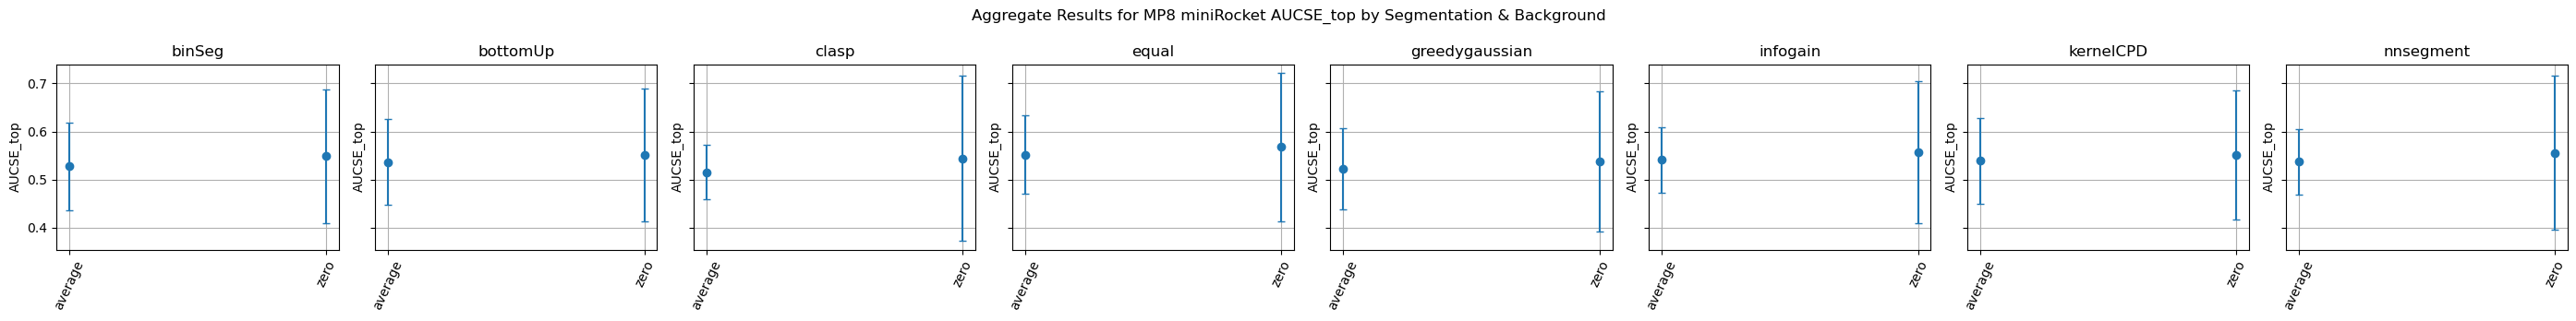

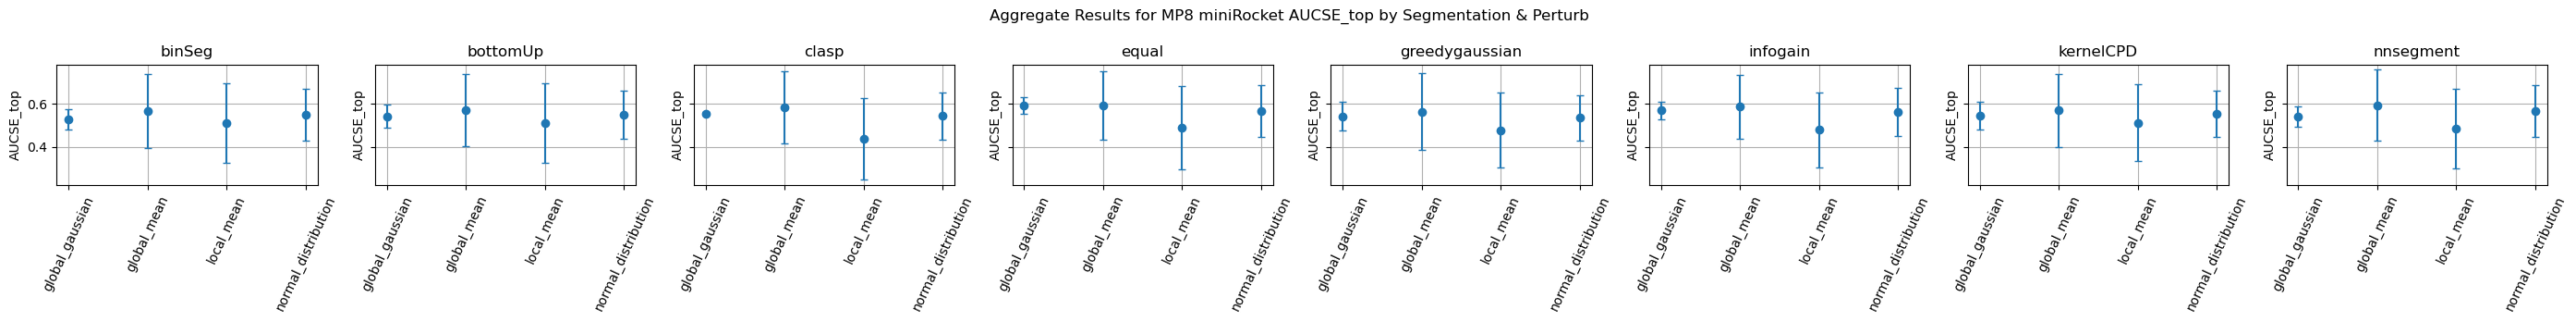

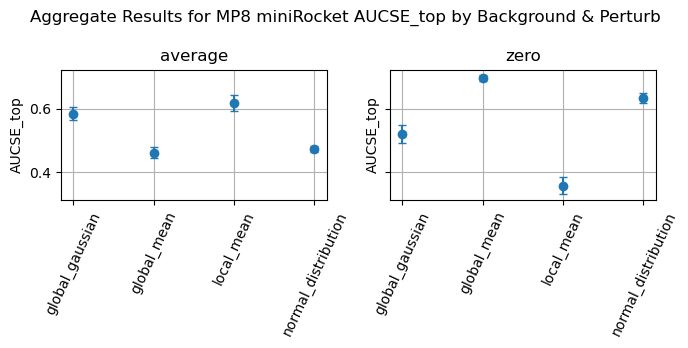

In [42]:
active_columns = columns_wo_result.copy()
active_columns.remove("Metric")
active_columns.remove("Normalization")
active_columns.remove("Dataset")
active_columns.remove("ML model")
active_combinations = list(combinations(active_columns, 2)) # [["Dataset", "ML model"]] #
metric_names = ["F-score", "AUCSE"]

for pair_of_interest in pairs_of_interest:
    dataset_name, ml_model_name = pair_of_interest

    for metric_name in metric_names:

        mask = (df["Metric"]==metric_name) & (df["Normalization"]=="default") & (df["Dataset"]==dataset_name) & (df["ML model"]==ml_model_name)
        df2 = df.loc[mask] # , ['Perturb', "Result"]
        # col_unique_lengths = []
        # for col in df2[active_columns]:
        #     col_unique_lengths.append(len(df2[col].unique()))
        # n_rows = len(active_combinations)
        # max_cols = np.max(col_unique_lengths)

        for column_names in active_combinations:
            column_names = column_names #[::-1]
            df3 = df2.groupby([*column_names]).agg({'Result': ["mean", "std"]})
            index_levels = df3.index.levels
            df3.columns = df3.columns.get_level_values(1)
            df3 = df3.reset_index()
            # print(dataset_name, ml_model_name, metric_name, column_names[0], column_names[1])
            # print(index_levels)

            n_cols = len(index_levels[0])

            fig, ax = plt.subplots(1, n_cols, figsize = (3.5*n_cols, 3.5), sharex=True, sharey=True) #dpi

            for j, column_name in enumerate(index_levels[0]):
                mask4 = df3[column_names[0]]==column_name
                df4 = df3.loc[mask4, [column_names[1], "mean", "std"]]
                df4 = df4.set_index(column_names[1])

                df4_mean = df4["mean"]
                df4_std = df4["std"]
                
                ax[j].errorbar(df4.index, df4_mean.values, df4_std.values, linestyle='None', marker='o', capsize=3)
                ax[j].grid()
                ax[j].tick_params("x", rotation=65)
                ax[j].set_title(column_name)
                ax[j].set_ylabel(metric_name)

                fig_name = f"Aggregate Results for {dataset_name} {ml_model_name} {metric_name} by {column_names[0]} & {column_names[1]}"
                fig.suptitle(fig_name)
                fig.tight_layout()
                fig.savefig(images_path + "/combinations/" + fig_name + ".png") # , dpi=100

In [55]:
pairs_of_interest = [("KeplerLightCurves", "resNet"), ("gunpoint", "miniRocket"), ("MP8", "miniRocket")]

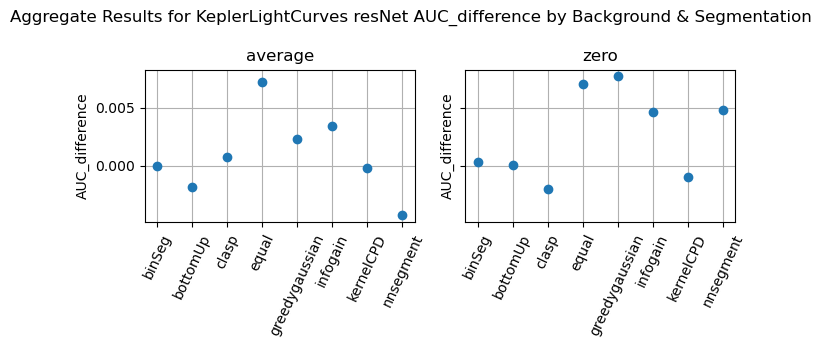

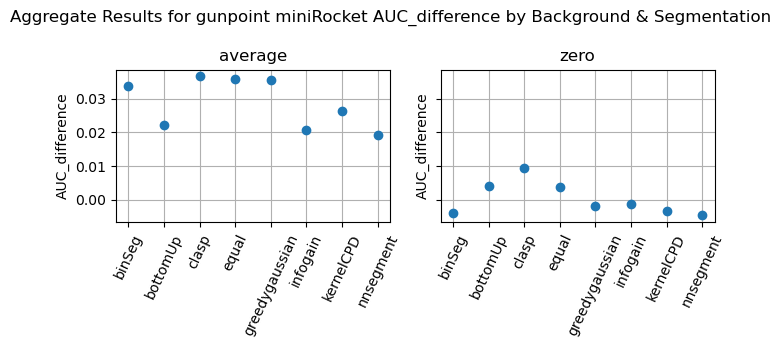

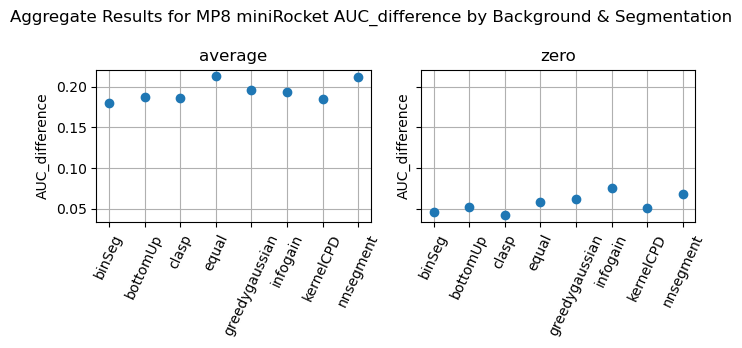

In [56]:
active_columns = columns_wo_result.copy()
active_columns.remove("Metric")
active_columns.remove("Normalization")
active_columns.remove("Dataset")
active_columns.remove("ML model")
active_columns.remove("Perturb")
active_combinations = list(combinations(active_columns, 2)) # [["Dataset", "ML model"]] #
metric_name = "AUCD"
perturb_names = ["mean"]

for pair_of_interest in pairs_of_interest:
    dataset_name, ml_model_name = pair_of_interest

    mask = (df["Metric"]==metric_name) & (df["Perturb"]==perturb_name) & (df["Normalization"]=="default") & (df["Dataset"]==dataset_name) & (df["ML model"]==ml_model_name)
    df2 = df.loc[mask] # , ['Perturb', "Result"]
        # col_unique_lengths = []
        # for col in df2[active_columns]:
        #     col_unique_lengths.append(len(df2[col].unique()))
        # n_rows = len(active_combinations)
        # max_cols = np.max(col_unique_lengths)

    for column_names in active_combinations:
        column_names = column_names[::-1]
        df3 = df2.groupby([*column_names]).agg({'Result': ["mean", "std"]})
        index_levels = df3.index.levels
        df3.columns = df3.columns.get_level_values(1)
        df3 = df3.reset_index()
        # print(dataset_name, ml_model_name, metric_name, column_names[0], column_names[1])
        # print(index_levels)

        n_cols = len(index_levels[0])

        fig, ax = plt.subplots(1, n_cols, figsize = (3.5*n_cols, 3.5), sharex=True, sharey=True) #dpi

        for j, column_name in enumerate(index_levels[0]):
            mask4 = df3[column_names[0]]==column_name
            df4 = df3.loc[mask4, [column_names[1], "mean", "std"]]
            df4 = df4.set_index(column_names[1])

            df4_mean = df4["mean"]
            df4_std = df4["std"]
            
            ax[j].errorbar(df4.index, df4_mean.values, df4_std.values, linestyle='None', marker='o', capsize=3)
            ax[j].grid()
            ax[j].tick_params("x", rotation=65)
            ax[j].set_title(column_name)
            ax[j].set_ylabel(metric_name)

            fig_name = f"Aggregate Results for {dataset_name} {ml_model_name} {metric_name} by {column_names[0]} & {column_names[1]}"
            fig.suptitle(fig_name)
            fig.tight_layout()
            fig.savefig(images_path + "/combinations/" + fig_name + ".png") # , dpi=100

In [ ]:
0/0

ZeroDivisionError: division by zero